# Attack Comments Classification
2020.09.12


Student: Xuanyu Su                                                                 
Supervisor: Isar Nejadgholi

## Data pre-processing

In [ ]:
!pip install transformers

In [31]:
source_folder = 'Data'
destination_folder = 'Model'

In [ ]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import torch
import transformers

# Preliminaries
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

# Models
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

# Training
import torch.optim as optim

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

In [32]:
comments = pd.read_csv('attack_annotated_comments.tsv',sep='\t',encoding = "ISO-8859-1")
annotation = pd.read_csv('attack_annotations.tsv',sep='\t',encoding = "ISO-8859-1")
worker = pd.read_csv('attack_worker_demographics.tsv',sep='\t',encoding = "ISO-8859-1")

In [33]:
comments.head()

,rev_id,comment,year,logged_in,ns,sample,split
0,37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,train
1,44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002,False,article,random,train
2,49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",2002,False,article,random,train
3,89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev
4,93890,This page will need disambiguation.,2002,True,article,random,train


In [34]:
annotation.head()

,rev_id,worker_id,quoting_attack,recipient_attack,third_party_attack,other_attack,attack
0,37675,1362,0.0,0.0,0.0,0.0,0.0
1,37675,2408,0.0,0.0,0.0,0.0,0.0
2,37675,1493,0.0,0.0,0.0,0.0,0.0
3,37675,1439,0.0,0.0,0.0,0.0,0.0
4,37675,170,0.0,0.0,0.0,0.0,0.0


In [36]:
# merge comment and annotation tables 
result = pd.merge(comments, annotation, how='left', on=['rev_id'])

In [ ]:
#remove duplicates in comment
result = result.drop_duplicates(subset=['comment'])

In [38]:
# replace the special words with ''
result['comment'] = result['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
result['comment'] = result['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

In [39]:
result.tail()

,rev_id,comment,year,logged_in,ns,sample,split,worker_id,quoting_attack,recipient_attack,third_party_attack,other_attack,attack
1365169,699848324,` These sources don't exactly exude a sense ...,2016,True,article,blocked,train,1842,0.0,0.0,0.0,0.0,0.0
1365178,699851288,The Institute for Historical Review is a pee...,2016,True,article,blocked,test,337,0.0,0.0,0.0,0.0,0.0
1365188,699857133,:The way you're trying to describe it in this...,2016,True,article,blocked,train,331,0.0,0.0,0.0,0.0,0.0
1365197,699891012,== Warning == There is clearly a protection...,2016,True,user,blocked,dev,2593,0.0,0.0,0.0,0.0,0.0
1365207,699897151,Alternate option=== Is there perhaps enough ne...,2016,True,article,blocked,train,151,0.0,0.0,0.0,0.0,0.0


In [40]:
result[result['attack'] == 1]['comment'].head()

492         The references to the Congolese economy se...
749             Iraq is not good  ===  ===  USA is bad   
758       Perhaps it was possible to have dual citizen...
1428    `GOD BLESS OUR FREEDOM FIGHTING TROOPS DEFEATI...
1561      == Some thoughts ==  I am going to hit the p...
Name: comment, dtype: object

In [41]:
# remove the irrelevant columns
result2 = result.drop(columns = ['rev_id','year','logged_in','ns','sample','worker_id',
                                 'quoting_attack','recipient_attack','third_party_attack','other_attack'])

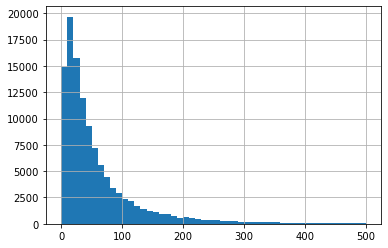

In [42]:
# get length of all the comments in the train set and plot hisgram
seq_len = [len(i.split()) for i in result2['comment']]
pd.Series(seq_len).hist(bins = 50,range=[0,500])

In [43]:
# split the data into train, validation and test
Train_comment = result2[result2['split']=='train']
dec_comment = result2[result2['split']=='dev']
test_comment = result2[result2['split']=='test']

In [44]:
# get the length of each table
print('length of train set is',len(Train_comment))
print('length of dev set is',len(dec_comment))
print('length of test set is',len(test_comment))

length of train set is 69426
length of dev set is 23135
length of test set is 23144


In [45]:
# drop the duplicate column
Train_comment = Train_comment.drop(columns = ['split'])
dec_comment = dec_comment.drop(columns = ['split'])
test_comment = test_comment.drop(columns = ['split'])

In [46]:
Train_comment.head()

,comment,attack
0,`- This is not ``creative``. Those are the di...,0.0
10,` :: the term ``standard model`` is itself le...,0.0
19,"True or false, the situation as of March 200...",0.0
38,This page will need disambiguation.,0.0
47,- Important note for all sysops: There is a ...,0.0


In [47]:
# check class distribution
Train_comment['attack'].value_counts(normalize = True)

0.0    0.830525
1.0    0.169475
Name: attack, dtype: float64

In [48]:
# save the splited tables into csv style
Train_comment.to_csv('Train_comment.csv',index=False,header=True)
dec_comment.to_csv('Val_comment.csv',index=False,header=True)
test_comment.to_csv('Test_comment.csv',index=False,header=True)

In [49]:
print(torch.__version__)
print(transformers.__version__)

1.6.0
3.1.0


## Define embedding methods

In [52]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [53]:
# the maximum length of sentences
MAX_SEQ_LEN = 128

# pad the sentences with less words than 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('comment', text_field),('attack', label_field)]

# TabularDataset
train, valid, test = TabularDataset.splits(path=source_folder, train='Train_comment.csv', validation='Val_comment.csv',
                                           test='Test_comment.csv', format='CSV', fields=fields, skip_header=True)


train_iter = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.comment),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=16, sort_key=lambda x: len(x.comment),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)

Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (541 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1088 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (593 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1057 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (897 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (697 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2000 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (779 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (568 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (558 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (913 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (516 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (848 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1490 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (894 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (862 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (701 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (723 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1089 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (2128 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (702 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (582 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (774 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (742 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (1747 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1036 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1338 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (665 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (770 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for 

Token indices sequence length is longer than the specified maximum sequence length for this model (622 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (9322 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3078 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1398 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1954 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for

Token indices sequence length is longer than the specified maximum sequence length for this model (588 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1109 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (592 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (675 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (946 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (870 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (857 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (911 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (911 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1012 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (547 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (814 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1557 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1666 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1040 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for 

Token indices sequence length is longer than the specified maximum sequence length for this model (721 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (819 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (692 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1380 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (963 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (1307 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1320 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (983 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1301 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2507 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for

Token indices sequence length is longer than the specified maximum sequence length for this model (522 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (936 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (530 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1364 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1256 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (1354 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (599 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1976 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (647 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2252 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for 

Token indices sequence length is longer than the specified maximum sequence length for this model (3750 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1643 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1988 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1984 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (736 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for

Token indices sequence length is longer than the specified maximum sequence length for this model (2152 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (536 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (534 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (552 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1874 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (1792 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (961 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (602 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (860 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (782 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (518 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1003 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (519 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (927 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2071 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (625 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2193 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (631 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (632 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (1268 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1055 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1374 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (559 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1137 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for

Token indices sequence length is longer than the specified maximum sequence length for this model (621 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (797 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2090 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1151 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1428 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for 

Token indices sequence length is longer than the specified maximum sequence length for this model (1079 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (856 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (847 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2170 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (843 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (577 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (619 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (578 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (748 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (875 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (2041 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2037 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2040 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1088 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (668 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for

Token indices sequence length is longer than the specified maximum sequence length for this model (740 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2127 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (617 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1724 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1000 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for 

Token indices sequence length is longer than the specified maximum sequence length for this model (792 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (698 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (913 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (606 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (536 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (567 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (603 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (807 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (661 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (833 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (2140 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (713 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (969 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2098 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1100 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for 

Token indices sequence length is longer than the specified maximum sequence length for this model (2677 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (958 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (793 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (897 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1166 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (852 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (643 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1133 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (897 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2667 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (573 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (668 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1036 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (538 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (575 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (515 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1274 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (574 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (716 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1261 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (776 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (512 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (547 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (650 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (558 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (771 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1197 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1064 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2730 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2021 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for

Token indices sequence length is longer than the specified maximum sequence length for this model (701 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (543 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (616 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1926 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (525 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (687 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1290 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1118 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1492 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (580 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for 

Token indices sequence length is longer than the specified maximum sequence length for this model (816 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (826 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (979 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (681 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (991 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (951 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (569 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (975 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (954 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1113 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (1694 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2408 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (542 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (529 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (614 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (1121 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1630 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (705 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1135 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (575 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for 

Token indices sequence length is longer than the specified maximum sequence length for this model (650 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1686 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (570 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (653 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (570 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (1731 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (715 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (849 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1958 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (556 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (801 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (532 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (599 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (564 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1418 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (786 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (810 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1070 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2582 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (860 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (778 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2131 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2422 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1589 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2279 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for

Token indices sequence length is longer than the specified maximum sequence length for this model (711 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (565 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (675 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (670 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (536 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (524 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (670 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (925 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (779 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (1211 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (687 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1566 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (774 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1547 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for 

Token indices sequence length is longer than the specified maximum sequence length for this model (624 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (536 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (828 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1067 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (615 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (2085 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (527 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1869 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (539 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (1606 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1939 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (564 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1142 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (745 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for 

Token indices sequence length is longer than the specified maximum sequence length for this model (1573 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (546 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (517 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (961 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (611 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (821 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (832 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (927 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (994 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1972 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (629 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1082 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (778 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2860 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2458 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for 

Token indices sequence length is longer than the specified maximum sequence length for this model (690 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (652 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (920 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (899 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (757 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (4546 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4001 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (545 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1304 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (593 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for 

Token indices sequence length is longer than the specified maximum sequence length for this model (1493 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (594 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1711 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (606 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (640 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (1129 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (534 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5771 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (631 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (528 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (871 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (857 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2129 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1177 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1184 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for 

Token indices sequence length is longer than the specified maximum sequence length for this model (577 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (829 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (657 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (543 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1463 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (554 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (526 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (975 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (895 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2083 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

## Model construction

In [22]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]
        

        return loss, text_fea

## Model Training and test

In [27]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):
    if save_path == None:
        return

    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

    
    
def load_checkpoint(load_path, model):
    if load_path==None:
        return
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']



def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):
    if save_path == None:
        return
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


    
def load_metrics(load_path):
    if load_path==None:
        return
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [66]:
# Training Function
def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        batch_no = 1
        for (comment, attack), _ in train_loader:
            attack = attack.type(torch.LongTensor)           
            attack = attack.to(device)
            comment = comment.type(torch.LongTensor)  
            comment = comment.to(device)
            output = model(comment, attack)
            loss, _ = output
            print('batch_no [{}/{}]:'.format(batch_no, int(len(Train_comment)/16)),'training_loss:',loss)
            batch_no+=1
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                # validation loop
                for (comment, attack), _ in valid_loader:
                    attack = attack.type(torch.LongTensor)           
                    attack = attack.to(device)
                    comment = comment.type(torch.LongTensor)  
                    comment = comment.to(device)
                    output = model(comment, attack)
                    loss, _ = output

                    valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [67]:
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

train(model=model, optimizer=optimizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

batch_no [1/4339]: training_loss: tensor(0.5370, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2/4339]: training_loss: tensor(0.6460, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3/4339]: training_loss: tensor(0.5828, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4/4339]: training_loss: tensor(0.4385, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [5/4339]: training_loss: tensor(0.4487, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [6/4339]: training_loss: tensor(0.5640, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [7/4339]: training_loss: tensor(0.4016, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [8/4339]: training_loss: tensor(0.1764, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [9/4339]: training_loss: tensor(0.3914, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [10/4339]: training_loss: tensor(0.2528, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [11/4339]: training_loss: tensor(0.2362, device='cuda:0', gr

batch_no [89/4339]: training_loss: tensor(0.4129, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [90/4339]: training_loss: tensor(0.5085, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [91/4339]: training_loss: tensor(0.6259, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [92/4339]: training_loss: tensor(0.3924, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [93/4339]: training_loss: tensor(0.4616, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [94/4339]: training_loss: tensor(0.3791, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [95/4339]: training_loss: tensor(0.3844, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [96/4339]: training_loss: tensor(0.3285, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [97/4339]: training_loss: tensor(0.7757, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [98/4339]: training_loss: tensor(0.4017, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [99/4339]: training_loss: tensor(0.8347, device='cu

batch_no [176/4339]: training_loss: tensor(0.3926, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [177/4339]: training_loss: tensor(0.6025, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [178/4339]: training_loss: tensor(0.3203, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [179/4339]: training_loss: tensor(0.4494, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [180/4339]: training_loss: tensor(0.3853, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [181/4339]: training_loss: tensor(0.5682, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [182/4339]: training_loss: tensor(0.5408, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [183/4339]: training_loss: tensor(0.4475, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [184/4339]: training_loss: tensor(0.5907, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [185/4339]: training_loss: tensor(0.3686, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [186/4339]: training_loss: tensor(0.4004,

batch_no [263/4339]: training_loss: tensor(0.3745, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [264/4339]: training_loss: tensor(0.4791, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [265/4339]: training_loss: tensor(0.1976, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [266/4339]: training_loss: tensor(0.5518, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [267/4339]: training_loss: tensor(0.2383, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [268/4339]: training_loss: tensor(0.3940, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [269/4339]: training_loss: tensor(0.5246, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [270/4339]: training_loss: tensor(0.2082, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [271/4339]: training_loss: tensor(0.2762, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [272/4339]: training_loss: tensor(0.3105, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [273/4339]: training_loss: tensor(0.3511,

batch_no [350/4339]: training_loss: tensor(0.3757, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [351/4339]: training_loss: tensor(0.2503, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [352/4339]: training_loss: tensor(0.3311, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [353/4339]: training_loss: tensor(0.2339, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [354/4339]: training_loss: tensor(0.2052, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [355/4339]: training_loss: tensor(0.3167, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [356/4339]: training_loss: tensor(0.0867, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [357/4339]: training_loss: tensor(0.0892, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [358/4339]: training_loss: tensor(0.2121, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [359/4339]: training_loss: tensor(0.1587, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [360/4339]: training_loss: tensor(0.4266,

batch_no [437/4339]: training_loss: tensor(0.4570, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [438/4339]: training_loss: tensor(0.2424, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [439/4339]: training_loss: tensor(0.2413, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [440/4339]: training_loss: tensor(0.3633, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [441/4339]: training_loss: tensor(0.2420, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [442/4339]: training_loss: tensor(0.1951, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [443/4339]: training_loss: tensor(0.1989, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [444/4339]: training_loss: tensor(0.3391, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [445/4339]: training_loss: tensor(0.4347, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [446/4339]: training_loss: tensor(0.2879, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [447/4339]: training_loss: tensor(0.4546,

batch_no [524/4339]: training_loss: tensor(0.3272, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [525/4339]: training_loss: tensor(0.7040, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [526/4339]: training_loss: tensor(0.3534, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [527/4339]: training_loss: tensor(0.0911, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [528/4339]: training_loss: tensor(0.2899, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [529/4339]: training_loss: tensor(0.3710, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [530/4339]: training_loss: tensor(0.4401, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [531/4339]: training_loss: tensor(0.1583, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [532/4339]: training_loss: tensor(0.1682, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [533/4339]: training_loss: tensor(0.0513, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [534/4339]: training_loss: tensor(0.1698,

batch_no [611/4339]: training_loss: tensor(0.5362, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [612/4339]: training_loss: tensor(0.4133, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [613/4339]: training_loss: tensor(0.1557, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [614/4339]: training_loss: tensor(0.2303, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [615/4339]: training_loss: tensor(0.2222, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [616/4339]: training_loss: tensor(0.1988, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [617/4339]: training_loss: tensor(0.2675, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [618/4339]: training_loss: tensor(0.0750, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [619/4339]: training_loss: tensor(0.3335, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [620/4339]: training_loss: tensor(0.6558, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [621/4339]: training_loss: tensor(0.2339,

batch_no [698/4339]: training_loss: tensor(0.2455, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [699/4339]: training_loss: tensor(0.5877, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [700/4339]: training_loss: tensor(0.1086, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [701/4339]: training_loss: tensor(0.1931, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [702/4339]: training_loss: tensor(0.3522, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [703/4339]: training_loss: tensor(0.2081, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [704/4339]: training_loss: tensor(0.2885, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [705/4339]: training_loss: tensor(0.2562, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [706/4339]: training_loss: tensor(0.1324, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [707/4339]: training_loss: tensor(0.4459, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [708/4339]: training_loss: tensor(0.3125,

batch_no [785/4339]: training_loss: tensor(0.3736, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [786/4339]: training_loss: tensor(0.4621, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [787/4339]: training_loss: tensor(0.4075, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [788/4339]: training_loss: tensor(0.2300, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [789/4339]: training_loss: tensor(0.5364, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [790/4339]: training_loss: tensor(0.4154, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [791/4339]: training_loss: tensor(0.3839, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [792/4339]: training_loss: tensor(0.3362, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [793/4339]: training_loss: tensor(0.5323, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [794/4339]: training_loss: tensor(0.2583, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [795/4339]: training_loss: tensor(0.5448,

batch_no [872/4339]: training_loss: tensor(0.1968, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [873/4339]: training_loss: tensor(0.2093, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [874/4339]: training_loss: tensor(0.2011, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [875/4339]: training_loss: tensor(0.2901, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [876/4339]: training_loss: tensor(0.5511, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [877/4339]: training_loss: tensor(0.1729, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [878/4339]: training_loss: tensor(0.3998, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [879/4339]: training_loss: tensor(0.4005, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [880/4339]: training_loss: tensor(0.3437, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [881/4339]: training_loss: tensor(0.6088, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [882/4339]: training_loss: tensor(0.2718,

batch_no [959/4339]: training_loss: tensor(0.1402, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [960/4339]: training_loss: tensor(1.0419, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [961/4339]: training_loss: tensor(0.0733, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [962/4339]: training_loss: tensor(0.1975, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [963/4339]: training_loss: tensor(0.1684, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [964/4339]: training_loss: tensor(0.0802, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [965/4339]: training_loss: tensor(0.5526, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [966/4339]: training_loss: tensor(0.5300, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [967/4339]: training_loss: tensor(0.3313, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [968/4339]: training_loss: tensor(0.2612, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [969/4339]: training_loss: tensor(0.1321,

batch_no [1045/4339]: training_loss: tensor(0.2824, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1046/4339]: training_loss: tensor(0.2021, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1047/4339]: training_loss: tensor(0.4598, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1048/4339]: training_loss: tensor(0.4219, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1049/4339]: training_loss: tensor(0.1940, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1050/4339]: training_loss: tensor(0.1653, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1051/4339]: training_loss: tensor(0.0961, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1052/4339]: training_loss: tensor(0.0690, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1053/4339]: training_loss: tensor(0.3101, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1054/4339]: training_loss: tensor(0.4307, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1055/4339]: training_loss: ten

batch_no [1131/4339]: training_loss: tensor(0.8134, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1132/4339]: training_loss: tensor(0.1214, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1133/4339]: training_loss: tensor(0.4170, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1134/4339]: training_loss: tensor(0.1948, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1135/4339]: training_loss: tensor(0.3338, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1136/4339]: training_loss: tensor(0.1963, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1137/4339]: training_loss: tensor(0.3645, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1138/4339]: training_loss: tensor(0.1082, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1139/4339]: training_loss: tensor(0.4915, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1140/4339]: training_loss: tensor(0.3353, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1141/4339]: training_loss: ten

batch_no [1217/4339]: training_loss: tensor(0.2490, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1218/4339]: training_loss: tensor(0.2283, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1219/4339]: training_loss: tensor(0.1307, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1220/4339]: training_loss: tensor(0.2957, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1221/4339]: training_loss: tensor(0.5124, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1222/4339]: training_loss: tensor(0.5620, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1223/4339]: training_loss: tensor(0.5653, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1224/4339]: training_loss: tensor(0.3399, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1225/4339]: training_loss: tensor(0.2194, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1226/4339]: training_loss: tensor(0.1777, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1227/4339]: training_loss: ten

batch_no [1303/4339]: training_loss: tensor(0.2157, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1304/4339]: training_loss: tensor(0.2932, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1305/4339]: training_loss: tensor(0.3950, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1306/4339]: training_loss: tensor(0.3417, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1307/4339]: training_loss: tensor(0.4411, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1308/4339]: training_loss: tensor(0.6076, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1309/4339]: training_loss: tensor(0.1550, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1310/4339]: training_loss: tensor(0.3425, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1311/4339]: training_loss: tensor(0.3676, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1312/4339]: training_loss: tensor(0.4008, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1313/4339]: training_loss: ten

batch_no [1389/4339]: training_loss: tensor(0.3402, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1390/4339]: training_loss: tensor(0.3583, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1391/4339]: training_loss: tensor(0.4133, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1392/4339]: training_loss: tensor(0.1814, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1393/4339]: training_loss: tensor(0.2091, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1394/4339]: training_loss: tensor(0.2437, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1395/4339]: training_loss: tensor(0.2129, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1396/4339]: training_loss: tensor(0.2285, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1397/4339]: training_loss: tensor(0.2766, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1398/4339]: training_loss: tensor(0.1104, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1399/4339]: training_loss: ten

batch_no [1475/4339]: training_loss: tensor(0.3649, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1476/4339]: training_loss: tensor(0.3322, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1477/4339]: training_loss: tensor(0.4865, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1478/4339]: training_loss: tensor(0.3690, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1479/4339]: training_loss: tensor(0.3725, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1480/4339]: training_loss: tensor(0.2614, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1481/4339]: training_loss: tensor(0.1564, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1482/4339]: training_loss: tensor(0.3633, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1483/4339]: training_loss: tensor(0.2337, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1484/4339]: training_loss: tensor(0.1404, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1485/4339]: training_loss: ten

batch_no [1561/4339]: training_loss: tensor(0.1194, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1562/4339]: training_loss: tensor(0.1241, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1563/4339]: training_loss: tensor(0.0723, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1564/4339]: training_loss: tensor(0.1949, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1565/4339]: training_loss: tensor(0.2809, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1566/4339]: training_loss: tensor(0.2526, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1567/4339]: training_loss: tensor(0.1135, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1568/4339]: training_loss: tensor(0.2641, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1569/4339]: training_loss: tensor(0.1356, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1570/4339]: training_loss: tensor(0.1597, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1571/4339]: training_loss: ten

batch_no [1647/4339]: training_loss: tensor(0.1933, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1648/4339]: training_loss: tensor(0.4466, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1649/4339]: training_loss: tensor(0.1267, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1650/4339]: training_loss: tensor(0.3563, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1651/4339]: training_loss: tensor(0.4506, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1652/4339]: training_loss: tensor(0.3673, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1653/4339]: training_loss: tensor(0.2239, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1654/4339]: training_loss: tensor(0.5038, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1655/4339]: training_loss: tensor(0.3528, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1656/4339]: training_loss: tensor(0.1644, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1657/4339]: training_loss: ten

batch_no [1733/4339]: training_loss: tensor(0.3696, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1734/4339]: training_loss: tensor(0.1577, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1735/4339]: training_loss: tensor(0.1644, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1736/4339]: training_loss: tensor(0.2278, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1737/4339]: training_loss: tensor(0.3750, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1738/4339]: training_loss: tensor(0.1280, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1739/4339]: training_loss: tensor(0.3033, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1740/4339]: training_loss: tensor(0.3613, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1741/4339]: training_loss: tensor(0.4670, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1742/4339]: training_loss: tensor(0.1891, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1743/4339]: training_loss: ten

batch_no [1819/4339]: training_loss: tensor(0.5740, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1820/4339]: training_loss: tensor(0.4332, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1821/4339]: training_loss: tensor(0.1477, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1822/4339]: training_loss: tensor(0.3961, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1823/4339]: training_loss: tensor(0.0834, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1824/4339]: training_loss: tensor(0.2779, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1825/4339]: training_loss: tensor(0.3035, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1826/4339]: training_loss: tensor(0.7149, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1827/4339]: training_loss: tensor(0.1275, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1828/4339]: training_loss: tensor(0.3111, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1829/4339]: training_loss: ten

batch_no [1905/4339]: training_loss: tensor(0.2163, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1906/4339]: training_loss: tensor(0.2831, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1907/4339]: training_loss: tensor(0.4091, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1908/4339]: training_loss: tensor(0.2024, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1909/4339]: training_loss: tensor(0.1070, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1910/4339]: training_loss: tensor(0.4419, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1911/4339]: training_loss: tensor(0.1972, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1912/4339]: training_loss: tensor(0.3490, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1913/4339]: training_loss: tensor(0.1449, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1914/4339]: training_loss: tensor(0.2117, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1915/4339]: training_loss: ten

batch_no [1991/4339]: training_loss: tensor(0.3728, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1992/4339]: training_loss: tensor(0.3269, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1993/4339]: training_loss: tensor(0.2923, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1994/4339]: training_loss: tensor(0.2383, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1995/4339]: training_loss: tensor(0.6782, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1996/4339]: training_loss: tensor(0.2137, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1997/4339]: training_loss: tensor(0.3456, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1998/4339]: training_loss: tensor(0.1865, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1999/4339]: training_loss: tensor(0.4142, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2000/4339]: training_loss: tensor(0.3498, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2001/4339]: training_loss: ten

batch_no [2077/4339]: training_loss: tensor(0.2997, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2078/4339]: training_loss: tensor(0.2393, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2079/4339]: training_loss: tensor(0.1733, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2080/4339]: training_loss: tensor(0.2314, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2081/4339]: training_loss: tensor(0.3392, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2082/4339]: training_loss: tensor(0.5441, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2083/4339]: training_loss: tensor(0.5929, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2084/4339]: training_loss: tensor(0.0734, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2085/4339]: training_loss: tensor(0.3369, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2086/4339]: training_loss: tensor(0.0683, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2087/4339]: training_loss: ten

batch_no [2163/4339]: training_loss: tensor(0.3576, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2164/4339]: training_loss: tensor(0.6483, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2165/4339]: training_loss: tensor(0.2721, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2166/4339]: training_loss: tensor(0.2089, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2167/4339]: training_loss: tensor(0.2934, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2168/4339]: training_loss: tensor(0.3180, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2169/4339]: training_loss: tensor(0.2180, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2170/4339]: training_loss: tensor(0.2115, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch [1/5], Step [2170/21700], Train Loss: 0.3253, Valid Loss: 0.3248
Model saved to ==> Model/model.pt
Model saved to ==> Model/metrics.pt
batch_no [2171/4339]: training_loss: tensor(0.2462, device='cuda:0', grad_fn=<NllLossBackwa

batch_no [2247/4339]: training_loss: tensor(0.4556, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2248/4339]: training_loss: tensor(0.4472, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2249/4339]: training_loss: tensor(0.2898, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2250/4339]: training_loss: tensor(0.6993, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2251/4339]: training_loss: tensor(0.2949, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2252/4339]: training_loss: tensor(0.2648, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2253/4339]: training_loss: tensor(0.0990, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2254/4339]: training_loss: tensor(0.3225, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2255/4339]: training_loss: tensor(0.2788, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2256/4339]: training_loss: tensor(0.4884, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2257/4339]: training_loss: ten

batch_no [2333/4339]: training_loss: tensor(0.3046, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2334/4339]: training_loss: tensor(0.1564, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2335/4339]: training_loss: tensor(0.1674, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2336/4339]: training_loss: tensor(0.4378, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2337/4339]: training_loss: tensor(0.2998, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2338/4339]: training_loss: tensor(0.3065, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2339/4339]: training_loss: tensor(0.5611, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2340/4339]: training_loss: tensor(0.5240, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2341/4339]: training_loss: tensor(0.2665, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2342/4339]: training_loss: tensor(0.4308, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2343/4339]: training_loss: ten

batch_no [2419/4339]: training_loss: tensor(0.3119, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2420/4339]: training_loss: tensor(0.2386, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2421/4339]: training_loss: tensor(0.2403, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2422/4339]: training_loss: tensor(0.2651, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2423/4339]: training_loss: tensor(0.2003, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2424/4339]: training_loss: tensor(0.3730, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2425/4339]: training_loss: tensor(0.6185, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2426/4339]: training_loss: tensor(0.3029, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2427/4339]: training_loss: tensor(0.0815, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2428/4339]: training_loss: tensor(0.1716, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2429/4339]: training_loss: ten

batch_no [2505/4339]: training_loss: tensor(0.2501, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2506/4339]: training_loss: tensor(0.1341, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2507/4339]: training_loss: tensor(0.3277, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2508/4339]: training_loss: tensor(0.3460, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2509/4339]: training_loss: tensor(0.2113, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2510/4339]: training_loss: tensor(0.0514, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2511/4339]: training_loss: tensor(0.1283, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2512/4339]: training_loss: tensor(0.2541, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2513/4339]: training_loss: tensor(0.1290, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2514/4339]: training_loss: tensor(0.2162, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2515/4339]: training_loss: ten

batch_no [2591/4339]: training_loss: tensor(0.1190, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2592/4339]: training_loss: tensor(0.3483, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2593/4339]: training_loss: tensor(0.1970, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2594/4339]: training_loss: tensor(0.2295, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2595/4339]: training_loss: tensor(0.0585, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2596/4339]: training_loss: tensor(0.5326, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2597/4339]: training_loss: tensor(0.1560, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2598/4339]: training_loss: tensor(0.3306, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2599/4339]: training_loss: tensor(0.1276, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2600/4339]: training_loss: tensor(0.7024, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2601/4339]: training_loss: ten

batch_no [2677/4339]: training_loss: tensor(0.3268, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2678/4339]: training_loss: tensor(0.3026, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2679/4339]: training_loss: tensor(0.2055, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2680/4339]: training_loss: tensor(0.1381, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2681/4339]: training_loss: tensor(0.2665, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2682/4339]: training_loss: tensor(0.2762, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2683/4339]: training_loss: tensor(0.4961, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2684/4339]: training_loss: tensor(0.1721, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2685/4339]: training_loss: tensor(0.0640, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2686/4339]: training_loss: tensor(0.2494, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2687/4339]: training_loss: ten

batch_no [2763/4339]: training_loss: tensor(0.2645, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2764/4339]: training_loss: tensor(0.2639, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2765/4339]: training_loss: tensor(0.2275, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2766/4339]: training_loss: tensor(0.2056, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2767/4339]: training_loss: tensor(0.2677, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2768/4339]: training_loss: tensor(0.5216, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2769/4339]: training_loss: tensor(0.3027, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2770/4339]: training_loss: tensor(0.1301, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2771/4339]: training_loss: tensor(0.3270, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2772/4339]: training_loss: tensor(0.0478, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2773/4339]: training_loss: ten

batch_no [2849/4339]: training_loss: tensor(0.3307, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2850/4339]: training_loss: tensor(0.2794, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2851/4339]: training_loss: tensor(0.1722, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2852/4339]: training_loss: tensor(0.3723, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2853/4339]: training_loss: tensor(0.1820, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2854/4339]: training_loss: tensor(0.6689, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2855/4339]: training_loss: tensor(0.1924, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2856/4339]: training_loss: tensor(0.4112, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2857/4339]: training_loss: tensor(0.6979, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2858/4339]: training_loss: tensor(0.2470, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2859/4339]: training_loss: ten

batch_no [2935/4339]: training_loss: tensor(0.5180, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2936/4339]: training_loss: tensor(0.1151, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2937/4339]: training_loss: tensor(0.3388, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2938/4339]: training_loss: tensor(0.5845, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2939/4339]: training_loss: tensor(0.0616, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2940/4339]: training_loss: tensor(0.4164, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2941/4339]: training_loss: tensor(0.5241, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2942/4339]: training_loss: tensor(0.2541, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2943/4339]: training_loss: tensor(0.2252, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2944/4339]: training_loss: tensor(0.3192, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2945/4339]: training_loss: ten

batch_no [3021/4339]: training_loss: tensor(0.6427, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3022/4339]: training_loss: tensor(0.5208, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3023/4339]: training_loss: tensor(0.4560, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3024/4339]: training_loss: tensor(0.2396, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3025/4339]: training_loss: tensor(0.3025, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3026/4339]: training_loss: tensor(0.1284, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3027/4339]: training_loss: tensor(0.1944, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3028/4339]: training_loss: tensor(0.5530, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3029/4339]: training_loss: tensor(0.3218, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3030/4339]: training_loss: tensor(0.1645, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3031/4339]: training_loss: ten

batch_no [3107/4339]: training_loss: tensor(0.0828, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3108/4339]: training_loss: tensor(0.2776, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3109/4339]: training_loss: tensor(0.1487, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3110/4339]: training_loss: tensor(0.4623, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3111/4339]: training_loss: tensor(0.1612, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3112/4339]: training_loss: tensor(0.0866, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3113/4339]: training_loss: tensor(0.1125, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3114/4339]: training_loss: tensor(0.2588, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3115/4339]: training_loss: tensor(0.5700, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3116/4339]: training_loss: tensor(0.3733, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3117/4339]: training_loss: ten

batch_no [3193/4339]: training_loss: tensor(0.2917, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3194/4339]: training_loss: tensor(0.1897, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3195/4339]: training_loss: tensor(0.5691, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3196/4339]: training_loss: tensor(0.1386, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3197/4339]: training_loss: tensor(0.3781, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3198/4339]: training_loss: tensor(0.1850, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3199/4339]: training_loss: tensor(0.3207, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3200/4339]: training_loss: tensor(0.3531, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3201/4339]: training_loss: tensor(0.2192, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3202/4339]: training_loss: tensor(0.1139, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3203/4339]: training_loss: ten

batch_no [3279/4339]: training_loss: tensor(0.4956, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3280/4339]: training_loss: tensor(0.3190, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3281/4339]: training_loss: tensor(0.1862, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3282/4339]: training_loss: tensor(0.2959, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3283/4339]: training_loss: tensor(0.1174, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3284/4339]: training_loss: tensor(0.4109, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3285/4339]: training_loss: tensor(0.3447, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3286/4339]: training_loss: tensor(0.3178, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3287/4339]: training_loss: tensor(0.1906, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3288/4339]: training_loss: tensor(0.4214, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3289/4339]: training_loss: ten

batch_no [3365/4339]: training_loss: tensor(0.3505, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3366/4339]: training_loss: tensor(0.1593, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3367/4339]: training_loss: tensor(0.2249, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3368/4339]: training_loss: tensor(0.3139, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3369/4339]: training_loss: tensor(0.1530, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3370/4339]: training_loss: tensor(0.2773, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3371/4339]: training_loss: tensor(0.3783, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3372/4339]: training_loss: tensor(0.4053, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3373/4339]: training_loss: tensor(0.3592, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3374/4339]: training_loss: tensor(0.1311, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3375/4339]: training_loss: ten

batch_no [3451/4339]: training_loss: tensor(0.2349, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3452/4339]: training_loss: tensor(0.2332, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3453/4339]: training_loss: tensor(0.3963, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3454/4339]: training_loss: tensor(0.4604, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3455/4339]: training_loss: tensor(0.1859, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3456/4339]: training_loss: tensor(0.1816, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3457/4339]: training_loss: tensor(0.1187, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3458/4339]: training_loss: tensor(0.3924, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3459/4339]: training_loss: tensor(0.1429, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3460/4339]: training_loss: tensor(0.1724, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3461/4339]: training_loss: ten

batch_no [3537/4339]: training_loss: tensor(0.2338, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3538/4339]: training_loss: tensor(0.1918, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3539/4339]: training_loss: tensor(0.4399, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3540/4339]: training_loss: tensor(0.2894, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3541/4339]: training_loss: tensor(0.2763, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3542/4339]: training_loss: tensor(0.6885, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3543/4339]: training_loss: tensor(0.1330, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3544/4339]: training_loss: tensor(0.3334, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3545/4339]: training_loss: tensor(0.0590, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3546/4339]: training_loss: tensor(0.2815, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3547/4339]: training_loss: ten

batch_no [3623/4339]: training_loss: tensor(0.4017, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3624/4339]: training_loss: tensor(0.3773, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3625/4339]: training_loss: tensor(0.3550, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3626/4339]: training_loss: tensor(0.3886, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3627/4339]: training_loss: tensor(0.3883, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3628/4339]: training_loss: tensor(0.5866, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3629/4339]: training_loss: tensor(0.3769, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3630/4339]: training_loss: tensor(0.2077, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3631/4339]: training_loss: tensor(0.3611, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3632/4339]: training_loss: tensor(0.3989, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3633/4339]: training_loss: ten

batch_no [3709/4339]: training_loss: tensor(0.7542, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3710/4339]: training_loss: tensor(0.4792, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3711/4339]: training_loss: tensor(0.1327, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3712/4339]: training_loss: tensor(0.1268, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3713/4339]: training_loss: tensor(0.2852, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3714/4339]: training_loss: tensor(0.4486, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3715/4339]: training_loss: tensor(0.3772, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3716/4339]: training_loss: tensor(0.3405, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3717/4339]: training_loss: tensor(0.3435, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3718/4339]: training_loss: tensor(0.2939, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3719/4339]: training_loss: ten

batch_no [3795/4339]: training_loss: tensor(0.1532, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3796/4339]: training_loss: tensor(0.2552, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3797/4339]: training_loss: tensor(0.3767, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3798/4339]: training_loss: tensor(0.4027, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3799/4339]: training_loss: tensor(0.3570, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3800/4339]: training_loss: tensor(0.3604, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3801/4339]: training_loss: tensor(0.3581, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3802/4339]: training_loss: tensor(0.3888, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3803/4339]: training_loss: tensor(0.5135, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3804/4339]: training_loss: tensor(0.2032, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3805/4339]: training_loss: ten

batch_no [3881/4339]: training_loss: tensor(0.2510, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3882/4339]: training_loss: tensor(0.3129, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3883/4339]: training_loss: tensor(0.6193, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3884/4339]: training_loss: tensor(0.6259, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3885/4339]: training_loss: tensor(0.3835, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3886/4339]: training_loss: tensor(0.2413, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3887/4339]: training_loss: tensor(0.3512, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3888/4339]: training_loss: tensor(0.5335, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3889/4339]: training_loss: tensor(0.5407, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3890/4339]: training_loss: tensor(0.4996, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3891/4339]: training_loss: ten

batch_no [3967/4339]: training_loss: tensor(0.1284, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3968/4339]: training_loss: tensor(0.2200, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3969/4339]: training_loss: tensor(0.3935, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3970/4339]: training_loss: tensor(0.3692, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3971/4339]: training_loss: tensor(0.2699, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3972/4339]: training_loss: tensor(0.1839, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3973/4339]: training_loss: tensor(0.2023, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3974/4339]: training_loss: tensor(0.0938, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3975/4339]: training_loss: tensor(0.1781, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3976/4339]: training_loss: tensor(0.4788, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3977/4339]: training_loss: ten

batch_no [4053/4339]: training_loss: tensor(0.9185, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4054/4339]: training_loss: tensor(0.3469, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4055/4339]: training_loss: tensor(0.3331, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4056/4339]: training_loss: tensor(0.4462, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4057/4339]: training_loss: tensor(0.3608, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4058/4339]: training_loss: tensor(0.4237, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4059/4339]: training_loss: tensor(0.2481, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4060/4339]: training_loss: tensor(0.2588, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4061/4339]: training_loss: tensor(0.1436, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4062/4339]: training_loss: tensor(0.2513, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4063/4339]: training_loss: ten

batch_no [4139/4339]: training_loss: tensor(0.4579, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4140/4339]: training_loss: tensor(0.1373, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4141/4339]: training_loss: tensor(0.1203, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4142/4339]: training_loss: tensor(0.2556, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4143/4339]: training_loss: tensor(0.3926, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4144/4339]: training_loss: tensor(0.3274, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4145/4339]: training_loss: tensor(0.2465, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4146/4339]: training_loss: tensor(0.2054, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4147/4339]: training_loss: tensor(0.2534, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4148/4339]: training_loss: tensor(0.3503, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4149/4339]: training_loss: ten

batch_no [4225/4339]: training_loss: tensor(0.3084, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4226/4339]: training_loss: tensor(0.3604, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4227/4339]: training_loss: tensor(0.3168, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4228/4339]: training_loss: tensor(0.3561, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4229/4339]: training_loss: tensor(0.3783, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4230/4339]: training_loss: tensor(0.2774, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4231/4339]: training_loss: tensor(0.4959, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4232/4339]: training_loss: tensor(0.1808, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4233/4339]: training_loss: tensor(0.3392, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4234/4339]: training_loss: tensor(0.4399, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4235/4339]: training_loss: ten

batch_no [4311/4339]: training_loss: tensor(0.4796, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4312/4339]: training_loss: tensor(0.3859, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4313/4339]: training_loss: tensor(0.2879, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4314/4339]: training_loss: tensor(0.3803, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4315/4339]: training_loss: tensor(0.2695, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4316/4339]: training_loss: tensor(0.3202, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4317/4339]: training_loss: tensor(0.8095, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4318/4339]: training_loss: tensor(0.3662, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4319/4339]: training_loss: tensor(0.3583, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4320/4339]: training_loss: tensor(0.4723, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4321/4339]: training_loss: ten

batch_no [57/4339]: training_loss: tensor(0.1671, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [58/4339]: training_loss: tensor(0.6098, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [59/4339]: training_loss: tensor(0.3908, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [60/4339]: training_loss: tensor(0.0667, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [61/4339]: training_loss: tensor(0.2864, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [62/4339]: training_loss: tensor(0.3260, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [63/4339]: training_loss: tensor(0.3605, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [64/4339]: training_loss: tensor(0.4742, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [65/4339]: training_loss: tensor(0.1962, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [66/4339]: training_loss: tensor(0.1402, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [67/4339]: training_loss: tensor(0.1743, device='cu

batch_no [144/4339]: training_loss: tensor(0.3256, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [145/4339]: training_loss: tensor(0.1406, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [146/4339]: training_loss: tensor(0.4179, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [147/4339]: training_loss: tensor(0.2409, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [148/4339]: training_loss: tensor(0.1046, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [149/4339]: training_loss: tensor(0.2592, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [150/4339]: training_loss: tensor(0.3518, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [151/4339]: training_loss: tensor(0.2288, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [152/4339]: training_loss: tensor(0.2718, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [153/4339]: training_loss: tensor(0.2009, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [154/4339]: training_loss: tensor(0.1504,

batch_no [231/4339]: training_loss: tensor(0.3857, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [232/4339]: training_loss: tensor(0.0481, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [233/4339]: training_loss: tensor(0.3558, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [234/4339]: training_loss: tensor(0.2726, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [235/4339]: training_loss: tensor(0.5738, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [236/4339]: training_loss: tensor(0.1761, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [237/4339]: training_loss: tensor(0.6119, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [238/4339]: training_loss: tensor(0.2225, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [239/4339]: training_loss: tensor(0.1191, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [240/4339]: training_loss: tensor(0.1922, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [241/4339]: training_loss: tensor(0.2655,

batch_no [318/4339]: training_loss: tensor(0.1906, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [319/4339]: training_loss: tensor(0.0473, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [320/4339]: training_loss: tensor(0.1181, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [321/4339]: training_loss: tensor(0.5478, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [322/4339]: training_loss: tensor(0.0761, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [323/4339]: training_loss: tensor(0.1105, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [324/4339]: training_loss: tensor(0.0629, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [325/4339]: training_loss: tensor(0.3591, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [326/4339]: training_loss: tensor(0.1753, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [327/4339]: training_loss: tensor(0.1813, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [328/4339]: training_loss: tensor(0.0918,

batch_no [405/4339]: training_loss: tensor(0.1786, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [406/4339]: training_loss: tensor(0.2299, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [407/4339]: training_loss: tensor(0.2840, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [408/4339]: training_loss: tensor(0.1615, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [409/4339]: training_loss: tensor(0.5200, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [410/4339]: training_loss: tensor(0.1042, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [411/4339]: training_loss: tensor(0.5704, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [412/4339]: training_loss: tensor(0.1399, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [413/4339]: training_loss: tensor(0.1204, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [414/4339]: training_loss: tensor(0.3728, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [415/4339]: training_loss: tensor(0.3898,

batch_no [492/4339]: training_loss: tensor(0.2627, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [493/4339]: training_loss: tensor(0.4351, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [494/4339]: training_loss: tensor(0.1374, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [495/4339]: training_loss: tensor(0.3746, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [496/4339]: training_loss: tensor(0.4537, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [497/4339]: training_loss: tensor(0.1452, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [498/4339]: training_loss: tensor(0.0524, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [499/4339]: training_loss: tensor(0.1138, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [500/4339]: training_loss: tensor(0.5768, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [501/4339]: training_loss: tensor(0.2128, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [502/4339]: training_loss: tensor(0.2127,

batch_no [579/4339]: training_loss: tensor(0.2024, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [580/4339]: training_loss: tensor(0.1838, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [581/4339]: training_loss: tensor(0.2018, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [582/4339]: training_loss: tensor(0.2088, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [583/4339]: training_loss: tensor(0.1850, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [584/4339]: training_loss: tensor(0.5737, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [585/4339]: training_loss: tensor(0.2173, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [586/4339]: training_loss: tensor(0.1381, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [587/4339]: training_loss: tensor(0.2301, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [588/4339]: training_loss: tensor(0.0550, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [589/4339]: training_loss: tensor(0.0998,

batch_no [666/4339]: training_loss: tensor(0.1436, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [667/4339]: training_loss: tensor(0.3458, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [668/4339]: training_loss: tensor(0.1712, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [669/4339]: training_loss: tensor(0.2482, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [670/4339]: training_loss: tensor(0.0859, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [671/4339]: training_loss: tensor(0.2701, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [672/4339]: training_loss: tensor(0.1082, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [673/4339]: training_loss: tensor(0.1453, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [674/4339]: training_loss: tensor(0.2420, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [675/4339]: training_loss: tensor(0.0702, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [676/4339]: training_loss: tensor(0.1050,

batch_no [753/4339]: training_loss: tensor(0.1814, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [754/4339]: training_loss: tensor(0.2099, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [755/4339]: training_loss: tensor(0.0639, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [756/4339]: training_loss: tensor(0.0727, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [757/4339]: training_loss: tensor(0.1905, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [758/4339]: training_loss: tensor(0.3089, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [759/4339]: training_loss: tensor(0.5882, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [760/4339]: training_loss: tensor(0.0953, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [761/4339]: training_loss: tensor(0.0208, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [762/4339]: training_loss: tensor(0.3607, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [763/4339]: training_loss: tensor(0.2865,

batch_no [840/4339]: training_loss: tensor(0.1018, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [841/4339]: training_loss: tensor(0.4021, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [842/4339]: training_loss: tensor(0.3187, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [843/4339]: training_loss: tensor(0.1120, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [844/4339]: training_loss: tensor(0.2663, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [845/4339]: training_loss: tensor(0.5195, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [846/4339]: training_loss: tensor(0.0527, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [847/4339]: training_loss: tensor(0.0739, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [848/4339]: training_loss: tensor(0.2330, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [849/4339]: training_loss: tensor(0.3416, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [850/4339]: training_loss: tensor(0.4484,

batch_no [927/4339]: training_loss: tensor(0.1581, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [928/4339]: training_loss: tensor(0.0704, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [929/4339]: training_loss: tensor(0.0271, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [930/4339]: training_loss: tensor(0.3379, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [931/4339]: training_loss: tensor(0.1941, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [932/4339]: training_loss: tensor(0.0409, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [933/4339]: training_loss: tensor(0.1737, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [934/4339]: training_loss: tensor(0.3115, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [935/4339]: training_loss: tensor(0.2693, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [936/4339]: training_loss: tensor(0.0367, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [937/4339]: training_loss: tensor(0.5722,

batch_no [1014/4339]: training_loss: tensor(0.3204, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1015/4339]: training_loss: tensor(0.2659, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1016/4339]: training_loss: tensor(0.2835, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1017/4339]: training_loss: tensor(0.2168, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1018/4339]: training_loss: tensor(0.5689, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1019/4339]: training_loss: tensor(0.3811, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1020/4339]: training_loss: tensor(0.5263, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1021/4339]: training_loss: tensor(0.2988, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1022/4339]: training_loss: tensor(0.4059, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1023/4339]: training_loss: tensor(0.4302, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1024/4339]: training_loss: ten

batch_no [1100/4339]: training_loss: tensor(0.1691, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1101/4339]: training_loss: tensor(0.4365, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1102/4339]: training_loss: tensor(0.0908, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1103/4339]: training_loss: tensor(0.5189, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1104/4339]: training_loss: tensor(0.2507, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1105/4339]: training_loss: tensor(0.1798, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1106/4339]: training_loss: tensor(0.3607, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1107/4339]: training_loss: tensor(0.2262, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1108/4339]: training_loss: tensor(0.4955, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1109/4339]: training_loss: tensor(0.2170, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1110/4339]: training_loss: ten

batch_no [1186/4339]: training_loss: tensor(0.3016, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1187/4339]: training_loss: tensor(0.1404, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1188/4339]: training_loss: tensor(0.3790, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1189/4339]: training_loss: tensor(0.2030, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1190/4339]: training_loss: tensor(0.0776, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1191/4339]: training_loss: tensor(0.1082, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1192/4339]: training_loss: tensor(0.2977, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1193/4339]: training_loss: tensor(0.0831, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1194/4339]: training_loss: tensor(0.2967, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1195/4339]: training_loss: tensor(0.3090, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1196/4339]: training_loss: ten

batch_no [1272/4339]: training_loss: tensor(0.1133, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1273/4339]: training_loss: tensor(0.1446, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1274/4339]: training_loss: tensor(0.2639, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1275/4339]: training_loss: tensor(0.1086, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1276/4339]: training_loss: tensor(0.1536, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1277/4339]: training_loss: tensor(0.2619, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1278/4339]: training_loss: tensor(0.1490, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1279/4339]: training_loss: tensor(0.3263, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1280/4339]: training_loss: tensor(0.2029, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1281/4339]: training_loss: tensor(0.0869, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1282/4339]: training_loss: ten

batch_no [1358/4339]: training_loss: tensor(0.1928, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1359/4339]: training_loss: tensor(0.3811, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1360/4339]: training_loss: tensor(0.1306, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1361/4339]: training_loss: tensor(0.2626, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1362/4339]: training_loss: tensor(0.3153, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1363/4339]: training_loss: tensor(0.3400, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1364/4339]: training_loss: tensor(0.2563, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1365/4339]: training_loss: tensor(0.1174, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1366/4339]: training_loss: tensor(0.6156, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1367/4339]: training_loss: tensor(0.1776, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1368/4339]: training_loss: ten

batch_no [1444/4339]: training_loss: tensor(0.2147, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1445/4339]: training_loss: tensor(0.1964, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1446/4339]: training_loss: tensor(0.2589, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1447/4339]: training_loss: tensor(0.2989, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1448/4339]: training_loss: tensor(0.3210, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1449/4339]: training_loss: tensor(0.1553, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1450/4339]: training_loss: tensor(0.3307, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1451/4339]: training_loss: tensor(0.2743, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1452/4339]: training_loss: tensor(0.4545, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1453/4339]: training_loss: tensor(0.3290, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1454/4339]: training_loss: ten

batch_no [1530/4339]: training_loss: tensor(0.4695, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1531/4339]: training_loss: tensor(0.2303, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1532/4339]: training_loss: tensor(0.0774, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1533/4339]: training_loss: tensor(0.1303, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1534/4339]: training_loss: tensor(0.1065, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1535/4339]: training_loss: tensor(0.3340, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1536/4339]: training_loss: tensor(0.0879, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1537/4339]: training_loss: tensor(0.4800, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1538/4339]: training_loss: tensor(0.2519, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1539/4339]: training_loss: tensor(0.5872, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1540/4339]: training_loss: ten

batch_no [1616/4339]: training_loss: tensor(0.5549, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1617/4339]: training_loss: tensor(0.2267, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1618/4339]: training_loss: tensor(0.1958, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1619/4339]: training_loss: tensor(0.1207, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1620/4339]: training_loss: tensor(0.0760, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1621/4339]: training_loss: tensor(0.1643, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1622/4339]: training_loss: tensor(0.2487, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1623/4339]: training_loss: tensor(0.2456, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1624/4339]: training_loss: tensor(0.3207, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1625/4339]: training_loss: tensor(0.5511, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1626/4339]: training_loss: ten

batch_no [1702/4339]: training_loss: tensor(0.4816, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1703/4339]: training_loss: tensor(0.1958, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1704/4339]: training_loss: tensor(0.3097, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1705/4339]: training_loss: tensor(0.4410, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1706/4339]: training_loss: tensor(0.1158, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1707/4339]: training_loss: tensor(0.1212, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1708/4339]: training_loss: tensor(0.2795, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1709/4339]: training_loss: tensor(0.1307, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1710/4339]: training_loss: tensor(0.3128, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1711/4339]: training_loss: tensor(0.2757, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1712/4339]: training_loss: ten

batch_no [1788/4339]: training_loss: tensor(0.2685, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1789/4339]: training_loss: tensor(0.1695, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1790/4339]: training_loss: tensor(0.0708, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1791/4339]: training_loss: tensor(0.6070, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1792/4339]: training_loss: tensor(0.1372, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1793/4339]: training_loss: tensor(0.2422, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1794/4339]: training_loss: tensor(0.1993, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1795/4339]: training_loss: tensor(0.1772, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1796/4339]: training_loss: tensor(0.3491, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1797/4339]: training_loss: tensor(0.3401, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1798/4339]: training_loss: ten

batch_no [1874/4339]: training_loss: tensor(0.1767, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1875/4339]: training_loss: tensor(0.4786, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1876/4339]: training_loss: tensor(0.1996, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1877/4339]: training_loss: tensor(0.1654, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1878/4339]: training_loss: tensor(0.5447, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1879/4339]: training_loss: tensor(0.1289, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1880/4339]: training_loss: tensor(0.2316, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1881/4339]: training_loss: tensor(0.2536, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1882/4339]: training_loss: tensor(0.2666, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1883/4339]: training_loss: tensor(0.6646, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1884/4339]: training_loss: ten

batch_no [1960/4339]: training_loss: tensor(0.2013, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1961/4339]: training_loss: tensor(0.1049, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1962/4339]: training_loss: tensor(0.2572, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1963/4339]: training_loss: tensor(0.2994, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1964/4339]: training_loss: tensor(0.1944, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1965/4339]: training_loss: tensor(0.1687, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1966/4339]: training_loss: tensor(0.5567, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1967/4339]: training_loss: tensor(0.3112, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1968/4339]: training_loss: tensor(0.0943, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1969/4339]: training_loss: tensor(0.0319, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1970/4339]: training_loss: ten

batch_no [2046/4339]: training_loss: tensor(0.2043, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2047/4339]: training_loss: tensor(0.4934, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2048/4339]: training_loss: tensor(0.2109, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2049/4339]: training_loss: tensor(0.2979, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2050/4339]: training_loss: tensor(0.1583, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2051/4339]: training_loss: tensor(0.2833, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2052/4339]: training_loss: tensor(0.0479, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2053/4339]: training_loss: tensor(0.4318, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2054/4339]: training_loss: tensor(0.2315, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2055/4339]: training_loss: tensor(0.2787, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2056/4339]: training_loss: ten

batch_no [2132/4339]: training_loss: tensor(0.4259, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2133/4339]: training_loss: tensor(0.1980, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2134/4339]: training_loss: tensor(0.1896, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2135/4339]: training_loss: tensor(0.1952, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2136/4339]: training_loss: tensor(0.5028, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2137/4339]: training_loss: tensor(0.3240, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2138/4339]: training_loss: tensor(0.3967, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2139/4339]: training_loss: tensor(0.1119, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2140/4339]: training_loss: tensor(0.1690, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2141/4339]: training_loss: tensor(0.1346, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2142/4339]: training_loss: ten

batch_no [2217/4339]: training_loss: tensor(0.1205, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2218/4339]: training_loss: tensor(0.2162, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2219/4339]: training_loss: tensor(0.4135, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2220/4339]: training_loss: tensor(0.4681, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2221/4339]: training_loss: tensor(0.4433, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2222/4339]: training_loss: tensor(0.1753, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2223/4339]: training_loss: tensor(0.5580, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2224/4339]: training_loss: tensor(0.1997, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2225/4339]: training_loss: tensor(0.3364, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2226/4339]: training_loss: tensor(0.5722, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2227/4339]: training_loss: ten

batch_no [2303/4339]: training_loss: tensor(0.4546, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2304/4339]: training_loss: tensor(0.5152, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2305/4339]: training_loss: tensor(0.3084, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2306/4339]: training_loss: tensor(0.1418, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2307/4339]: training_loss: tensor(0.2761, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2308/4339]: training_loss: tensor(0.5154, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2309/4339]: training_loss: tensor(0.5155, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2310/4339]: training_loss: tensor(0.1348, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2311/4339]: training_loss: tensor(0.4852, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2312/4339]: training_loss: tensor(0.6690, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2313/4339]: training_loss: ten

batch_no [2389/4339]: training_loss: tensor(0.1370, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2390/4339]: training_loss: tensor(0.1875, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2391/4339]: training_loss: tensor(0.3271, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2392/4339]: training_loss: tensor(0.0598, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2393/4339]: training_loss: tensor(0.1326, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2394/4339]: training_loss: tensor(0.5258, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2395/4339]: training_loss: tensor(0.1313, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2396/4339]: training_loss: tensor(0.1962, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2397/4339]: training_loss: tensor(0.0766, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2398/4339]: training_loss: tensor(0.3473, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2399/4339]: training_loss: ten

batch_no [2475/4339]: training_loss: tensor(0.4266, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2476/4339]: training_loss: tensor(0.2630, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2477/4339]: training_loss: tensor(0.2332, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2478/4339]: training_loss: tensor(0.2716, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2479/4339]: training_loss: tensor(0.1362, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2480/4339]: training_loss: tensor(0.4741, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2481/4339]: training_loss: tensor(0.2537, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2482/4339]: training_loss: tensor(0.2624, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2483/4339]: training_loss: tensor(0.2532, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2484/4339]: training_loss: tensor(0.3434, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2485/4339]: training_loss: ten

batch_no [2561/4339]: training_loss: tensor(0.3383, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2562/4339]: training_loss: tensor(0.5464, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2563/4339]: training_loss: tensor(0.1962, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2564/4339]: training_loss: tensor(0.2312, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2565/4339]: training_loss: tensor(0.1713, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2566/4339]: training_loss: tensor(0.5875, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2567/4339]: training_loss: tensor(0.2297, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2568/4339]: training_loss: tensor(0.3364, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2569/4339]: training_loss: tensor(0.0747, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2570/4339]: training_loss: tensor(0.4805, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2571/4339]: training_loss: ten

batch_no [2647/4339]: training_loss: tensor(0.1743, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2648/4339]: training_loss: tensor(0.4263, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2649/4339]: training_loss: tensor(0.2621, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2650/4339]: training_loss: tensor(0.0727, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2651/4339]: training_loss: tensor(0.1249, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2652/4339]: training_loss: tensor(0.2215, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2653/4339]: training_loss: tensor(0.2035, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2654/4339]: training_loss: tensor(0.0507, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2655/4339]: training_loss: tensor(0.0441, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2656/4339]: training_loss: tensor(0.1276, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2657/4339]: training_loss: ten

batch_no [2733/4339]: training_loss: tensor(0.5201, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2734/4339]: training_loss: tensor(0.5350, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2735/4339]: training_loss: tensor(0.4429, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2736/4339]: training_loss: tensor(0.5272, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2737/4339]: training_loss: tensor(0.3961, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2738/4339]: training_loss: tensor(0.2041, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2739/4339]: training_loss: tensor(0.2421, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2740/4339]: training_loss: tensor(0.3999, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2741/4339]: training_loss: tensor(0.3829, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2742/4339]: training_loss: tensor(0.3169, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2743/4339]: training_loss: ten

batch_no [2819/4339]: training_loss: tensor(0.3071, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2820/4339]: training_loss: tensor(0.2164, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2821/4339]: training_loss: tensor(0.0819, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2822/4339]: training_loss: tensor(0.1574, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2823/4339]: training_loss: tensor(0.2652, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2824/4339]: training_loss: tensor(0.1574, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2825/4339]: training_loss: tensor(0.4206, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2826/4339]: training_loss: tensor(0.0921, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2827/4339]: training_loss: tensor(0.4421, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2828/4339]: training_loss: tensor(0.3582, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2829/4339]: training_loss: ten

batch_no [2905/4339]: training_loss: tensor(0.4081, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2906/4339]: training_loss: tensor(0.2323, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2907/4339]: training_loss: tensor(0.2431, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2908/4339]: training_loss: tensor(0.2772, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2909/4339]: training_loss: tensor(0.3086, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2910/4339]: training_loss: tensor(0.2466, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2911/4339]: training_loss: tensor(0.1621, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2912/4339]: training_loss: tensor(0.3791, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2913/4339]: training_loss: tensor(0.4442, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2914/4339]: training_loss: tensor(0.1302, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2915/4339]: training_loss: ten

batch_no [2991/4339]: training_loss: tensor(0.1767, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2992/4339]: training_loss: tensor(0.3747, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2993/4339]: training_loss: tensor(0.1669, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2994/4339]: training_loss: tensor(0.2279, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2995/4339]: training_loss: tensor(0.3495, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2996/4339]: training_loss: tensor(0.3757, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2997/4339]: training_loss: tensor(0.1955, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2998/4339]: training_loss: tensor(0.1618, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2999/4339]: training_loss: tensor(0.1217, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3000/4339]: training_loss: tensor(0.2698, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3001/4339]: training_loss: ten

batch_no [3077/4339]: training_loss: tensor(0.1424, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3078/4339]: training_loss: tensor(0.2035, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3079/4339]: training_loss: tensor(0.2311, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3080/4339]: training_loss: tensor(0.2405, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3081/4339]: training_loss: tensor(0.1618, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3082/4339]: training_loss: tensor(0.0716, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3083/4339]: training_loss: tensor(0.1559, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3084/4339]: training_loss: tensor(0.1467, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3085/4339]: training_loss: tensor(0.0333, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3086/4339]: training_loss: tensor(0.3526, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3087/4339]: training_loss: ten

batch_no [3163/4339]: training_loss: tensor(0.4025, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3164/4339]: training_loss: tensor(0.3798, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3165/4339]: training_loss: tensor(0.2880, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3166/4339]: training_loss: tensor(0.2405, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3167/4339]: training_loss: tensor(0.4682, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3168/4339]: training_loss: tensor(0.1506, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3169/4339]: training_loss: tensor(0.5937, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3170/4339]: training_loss: tensor(0.2704, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3171/4339]: training_loss: tensor(0.1164, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3172/4339]: training_loss: tensor(0.2859, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3173/4339]: training_loss: ten

batch_no [3249/4339]: training_loss: tensor(0.1477, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3250/4339]: training_loss: tensor(0.0855, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3251/4339]: training_loss: tensor(0.1775, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3252/4339]: training_loss: tensor(0.2876, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3253/4339]: training_loss: tensor(0.0641, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3254/4339]: training_loss: tensor(0.1618, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3255/4339]: training_loss: tensor(0.3326, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3256/4339]: training_loss: tensor(0.1888, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3257/4339]: training_loss: tensor(0.1312, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3258/4339]: training_loss: tensor(0.5895, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3259/4339]: training_loss: ten

batch_no [3335/4339]: training_loss: tensor(0.3753, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3336/4339]: training_loss: tensor(0.2051, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3337/4339]: training_loss: tensor(0.2016, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3338/4339]: training_loss: tensor(0.1010, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3339/4339]: training_loss: tensor(0.3122, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3340/4339]: training_loss: tensor(0.2606, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3341/4339]: training_loss: tensor(0.1899, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3342/4339]: training_loss: tensor(0.1474, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3343/4339]: training_loss: tensor(0.1701, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3344/4339]: training_loss: tensor(0.1242, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3345/4339]: training_loss: ten

batch_no [3421/4339]: training_loss: tensor(0.2079, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3422/4339]: training_loss: tensor(1.0016, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3423/4339]: training_loss: tensor(0.1031, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3424/4339]: training_loss: tensor(0.1144, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3425/4339]: training_loss: tensor(0.3324, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3426/4339]: training_loss: tensor(0.1816, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3427/4339]: training_loss: tensor(0.2947, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3428/4339]: training_loss: tensor(0.4074, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3429/4339]: training_loss: tensor(0.3471, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3430/4339]: training_loss: tensor(0.2719, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3431/4339]: training_loss: ten

batch_no [3507/4339]: training_loss: tensor(0.3968, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3508/4339]: training_loss: tensor(0.2415, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3509/4339]: training_loss: tensor(0.3890, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3510/4339]: training_loss: tensor(0.4265, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3511/4339]: training_loss: tensor(0.1202, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3512/4339]: training_loss: tensor(0.5705, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3513/4339]: training_loss: tensor(0.1576, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3514/4339]: training_loss: tensor(0.1765, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3515/4339]: training_loss: tensor(0.3248, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3516/4339]: training_loss: tensor(0.4982, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3517/4339]: training_loss: ten

batch_no [3593/4339]: training_loss: tensor(0.5219, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3594/4339]: training_loss: tensor(0.2568, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3595/4339]: training_loss: tensor(0.1295, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3596/4339]: training_loss: tensor(0.5886, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3597/4339]: training_loss: tensor(0.0797, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3598/4339]: training_loss: tensor(0.3927, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3599/4339]: training_loss: tensor(0.1148, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3600/4339]: training_loss: tensor(0.3201, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3601/4339]: training_loss: tensor(0.2095, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3602/4339]: training_loss: tensor(0.2547, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3603/4339]: training_loss: ten

batch_no [3679/4339]: training_loss: tensor(0.5870, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3680/4339]: training_loss: tensor(0.2858, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3681/4339]: training_loss: tensor(0.6150, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3682/4339]: training_loss: tensor(0.1854, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3683/4339]: training_loss: tensor(0.3437, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3684/4339]: training_loss: tensor(0.4902, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3685/4339]: training_loss: tensor(0.3493, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3686/4339]: training_loss: tensor(0.3030, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3687/4339]: training_loss: tensor(0.2763, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3688/4339]: training_loss: tensor(0.3466, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3689/4339]: training_loss: ten

batch_no [3765/4339]: training_loss: tensor(0.2704, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3766/4339]: training_loss: tensor(0.3090, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3767/4339]: training_loss: tensor(0.3604, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3768/4339]: training_loss: tensor(0.1657, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3769/4339]: training_loss: tensor(0.1496, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3770/4339]: training_loss: tensor(0.1169, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3771/4339]: training_loss: tensor(0.2196, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3772/4339]: training_loss: tensor(0.1098, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3773/4339]: training_loss: tensor(0.2530, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3774/4339]: training_loss: tensor(0.1145, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3775/4339]: training_loss: ten

batch_no [3851/4339]: training_loss: tensor(0.2762, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3852/4339]: training_loss: tensor(0.3822, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3853/4339]: training_loss: tensor(0.0938, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3854/4339]: training_loss: tensor(0.2443, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3855/4339]: training_loss: tensor(0.5486, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3856/4339]: training_loss: tensor(0.1952, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3857/4339]: training_loss: tensor(0.3984, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3858/4339]: training_loss: tensor(0.0932, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3859/4339]: training_loss: tensor(0.3468, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3860/4339]: training_loss: tensor(0.1949, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3861/4339]: training_loss: ten

batch_no [3937/4339]: training_loss: tensor(0.4920, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3938/4339]: training_loss: tensor(0.3173, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3939/4339]: training_loss: tensor(0.2039, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3940/4339]: training_loss: tensor(0.3451, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3941/4339]: training_loss: tensor(0.1872, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3942/4339]: training_loss: tensor(0.1565, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3943/4339]: training_loss: tensor(0.0949, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3944/4339]: training_loss: tensor(0.1680, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3945/4339]: training_loss: tensor(0.2270, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3946/4339]: training_loss: tensor(0.0738, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3947/4339]: training_loss: ten

batch_no [4023/4339]: training_loss: tensor(0.1527, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4024/4339]: training_loss: tensor(0.5910, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4025/4339]: training_loss: tensor(0.3875, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4026/4339]: training_loss: tensor(0.4566, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4027/4339]: training_loss: tensor(0.2521, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4028/4339]: training_loss: tensor(0.1812, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4029/4339]: training_loss: tensor(0.5688, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4030/4339]: training_loss: tensor(0.3651, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4031/4339]: training_loss: tensor(0.4452, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4032/4339]: training_loss: tensor(0.6081, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4033/4339]: training_loss: ten

batch_no [4109/4339]: training_loss: tensor(0.4188, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4110/4339]: training_loss: tensor(0.2278, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4111/4339]: training_loss: tensor(0.1798, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4112/4339]: training_loss: tensor(0.3519, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4113/4339]: training_loss: tensor(0.4304, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4114/4339]: training_loss: tensor(0.2051, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4115/4339]: training_loss: tensor(0.3015, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4116/4339]: training_loss: tensor(0.1478, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4117/4339]: training_loss: tensor(0.3090, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4118/4339]: training_loss: tensor(0.0928, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4119/4339]: training_loss: ten

batch_no [4195/4339]: training_loss: tensor(0.2245, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4196/4339]: training_loss: tensor(0.1949, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4197/4339]: training_loss: tensor(0.3750, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4198/4339]: training_loss: tensor(0.4341, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4199/4339]: training_loss: tensor(0.1592, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4200/4339]: training_loss: tensor(0.1825, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4201/4339]: training_loss: tensor(0.2929, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4202/4339]: training_loss: tensor(0.2659, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4203/4339]: training_loss: tensor(0.6454, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4204/4339]: training_loss: tensor(0.2740, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4205/4339]: training_loss: ten

batch_no [4281/4339]: training_loss: tensor(0.2764, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4282/4339]: training_loss: tensor(0.6077, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4283/4339]: training_loss: tensor(0.2191, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4284/4339]: training_loss: tensor(0.3967, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4285/4339]: training_loss: tensor(0.1017, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4286/4339]: training_loss: tensor(0.0707, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4287/4339]: training_loss: tensor(0.1114, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4288/4339]: training_loss: tensor(0.0961, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4289/4339]: training_loss: tensor(0.5648, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4290/4339]: training_loss: tensor(0.0793, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4291/4339]: training_loss: ten

batch_no [27/4339]: training_loss: tensor(0.1349, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [28/4339]: training_loss: tensor(0.0619, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [29/4339]: training_loss: tensor(0.0410, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [30/4339]: training_loss: tensor(0.4370, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [31/4339]: training_loss: tensor(0.2635, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [32/4339]: training_loss: tensor(0.0289, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [33/4339]: training_loss: tensor(0.2035, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [34/4339]: training_loss: tensor(0.7985, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [35/4339]: training_loss: tensor(0.4027, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [36/4339]: training_loss: tensor(0.2778, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [37/4339]: training_loss: tensor(0.1263, device='cu

batch_no [115/4339]: training_loss: tensor(0.1190, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [116/4339]: training_loss: tensor(0.0867, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [117/4339]: training_loss: tensor(0.3192, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [118/4339]: training_loss: tensor(0.3240, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [119/4339]: training_loss: tensor(0.2236, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [120/4339]: training_loss: tensor(0.3978, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [121/4339]: training_loss: tensor(0.1852, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [122/4339]: training_loss: tensor(0.1272, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [123/4339]: training_loss: tensor(0.7617, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [124/4339]: training_loss: tensor(0.2248, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [125/4339]: training_loss: tensor(0.5200,

batch_no [202/4339]: training_loss: tensor(0.2824, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [203/4339]: training_loss: tensor(0.5157, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [204/4339]: training_loss: tensor(0.3787, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [205/4339]: training_loss: tensor(0.1062, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [206/4339]: training_loss: tensor(0.1392, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [207/4339]: training_loss: tensor(0.0354, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [208/4339]: training_loss: tensor(0.1397, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [209/4339]: training_loss: tensor(0.2039, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [210/4339]: training_loss: tensor(0.4869, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [211/4339]: training_loss: tensor(0.2881, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [212/4339]: training_loss: tensor(0.0683,

batch_no [289/4339]: training_loss: tensor(0.3019, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [290/4339]: training_loss: tensor(0.2988, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [291/4339]: training_loss: tensor(0.2074, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [292/4339]: training_loss: tensor(0.1037, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [293/4339]: training_loss: tensor(0.1785, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [294/4339]: training_loss: tensor(0.0887, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [295/4339]: training_loss: tensor(0.1356, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [296/4339]: training_loss: tensor(0.0888, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [297/4339]: training_loss: tensor(0.3578, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [298/4339]: training_loss: tensor(0.1526, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [299/4339]: training_loss: tensor(0.2438,

batch_no [376/4339]: training_loss: tensor(0.4344, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [377/4339]: training_loss: tensor(0.1109, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [378/4339]: training_loss: tensor(0.1118, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [379/4339]: training_loss: tensor(0.2219, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [380/4339]: training_loss: tensor(0.1026, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [381/4339]: training_loss: tensor(0.3438, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [382/4339]: training_loss: tensor(0.6555, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [383/4339]: training_loss: tensor(0.0802, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [384/4339]: training_loss: tensor(0.5352, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [385/4339]: training_loss: tensor(0.3392, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [386/4339]: training_loss: tensor(0.1306,

batch_no [463/4339]: training_loss: tensor(0.1428, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [464/4339]: training_loss: tensor(0.0308, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [465/4339]: training_loss: tensor(0.1141, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [466/4339]: training_loss: tensor(0.3424, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [467/4339]: training_loss: tensor(0.3701, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [468/4339]: training_loss: tensor(0.0478, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [469/4339]: training_loss: tensor(0.1106, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [470/4339]: training_loss: tensor(0.0994, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [471/4339]: training_loss: tensor(0.0448, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [472/4339]: training_loss: tensor(0.1423, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [473/4339]: training_loss: tensor(0.2476,

batch_no [550/4339]: training_loss: tensor(0.1372, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [551/4339]: training_loss: tensor(0.4052, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [552/4339]: training_loss: tensor(0.0801, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [553/4339]: training_loss: tensor(0.0178, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [554/4339]: training_loss: tensor(0.0393, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [555/4339]: training_loss: tensor(0.1655, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [556/4339]: training_loss: tensor(0.0967, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [557/4339]: training_loss: tensor(0.2788, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [558/4339]: training_loss: tensor(0.1520, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [559/4339]: training_loss: tensor(0.0787, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [560/4339]: training_loss: tensor(0.0412,

batch_no [637/4339]: training_loss: tensor(0.0640, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [638/4339]: training_loss: tensor(0.0287, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [639/4339]: training_loss: tensor(0.3500, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [640/4339]: training_loss: tensor(0.1075, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [641/4339]: training_loss: tensor(0.8617, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [642/4339]: training_loss: tensor(0.2990, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [643/4339]: training_loss: tensor(0.0679, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [644/4339]: training_loss: tensor(0.3802, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [645/4339]: training_loss: tensor(0.1557, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [646/4339]: training_loss: tensor(0.1549, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [647/4339]: training_loss: tensor(0.0702,

batch_no [724/4339]: training_loss: tensor(0.1920, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [725/4339]: training_loss: tensor(0.0532, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [726/4339]: training_loss: tensor(0.1972, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [727/4339]: training_loss: tensor(0.3326, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [728/4339]: training_loss: tensor(0.0865, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [729/4339]: training_loss: tensor(0.2051, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [730/4339]: training_loss: tensor(0.0797, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [731/4339]: training_loss: tensor(0.3095, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [732/4339]: training_loss: tensor(0.1226, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [733/4339]: training_loss: tensor(0.1152, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [734/4339]: training_loss: tensor(0.1209,

batch_no [811/4339]: training_loss: tensor(0.1865, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [812/4339]: training_loss: tensor(0.2043, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [813/4339]: training_loss: tensor(0.1526, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [814/4339]: training_loss: tensor(0.0796, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [815/4339]: training_loss: tensor(0.3630, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [816/4339]: training_loss: tensor(0.1380, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [817/4339]: training_loss: tensor(0.1368, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [818/4339]: training_loss: tensor(0.1150, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [819/4339]: training_loss: tensor(0.0429, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [820/4339]: training_loss: tensor(0.5545, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [821/4339]: training_loss: tensor(0.1095,

batch_no [898/4339]: training_loss: tensor(0.1294, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [899/4339]: training_loss: tensor(0.2713, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [900/4339]: training_loss: tensor(0.4361, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [901/4339]: training_loss: tensor(0.0656, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [902/4339]: training_loss: tensor(0.2861, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [903/4339]: training_loss: tensor(0.3542, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [904/4339]: training_loss: tensor(0.2016, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [905/4339]: training_loss: tensor(0.0836, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [906/4339]: training_loss: tensor(0.0530, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [907/4339]: training_loss: tensor(0.2358, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [908/4339]: training_loss: tensor(0.1470,

batch_no [985/4339]: training_loss: tensor(0.0738, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [986/4339]: training_loss: tensor(0.0407, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [987/4339]: training_loss: tensor(0.3139, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [988/4339]: training_loss: tensor(0.0996, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [989/4339]: training_loss: tensor(0.2815, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [990/4339]: training_loss: tensor(0.1314, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [991/4339]: training_loss: tensor(0.2692, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [992/4339]: training_loss: tensor(0.1833, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [993/4339]: training_loss: tensor(0.0510, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [994/4339]: training_loss: tensor(0.2533, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [995/4339]: training_loss: tensor(0.1719,

batch_no [1071/4339]: training_loss: tensor(0.2762, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1072/4339]: training_loss: tensor(0.4421, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1073/4339]: training_loss: tensor(0.1095, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1074/4339]: training_loss: tensor(0.2097, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1075/4339]: training_loss: tensor(0.1688, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1076/4339]: training_loss: tensor(0.2439, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1077/4339]: training_loss: tensor(0.2520, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1078/4339]: training_loss: tensor(0.1869, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1079/4339]: training_loss: tensor(0.5948, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1080/4339]: training_loss: tensor(0.1397, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1081/4339]: training_loss: ten

batch_no [1157/4339]: training_loss: tensor(0.2543, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1158/4339]: training_loss: tensor(0.3159, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1159/4339]: training_loss: tensor(0.2805, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1160/4339]: training_loss: tensor(0.2500, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1161/4339]: training_loss: tensor(0.4667, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1162/4339]: training_loss: tensor(0.3080, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1163/4339]: training_loss: tensor(0.2925, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1164/4339]: training_loss: tensor(0.2998, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1165/4339]: training_loss: tensor(0.5711, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1166/4339]: training_loss: tensor(0.3452, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1167/4339]: training_loss: ten

batch_no [1243/4339]: training_loss: tensor(0.0513, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1244/4339]: training_loss: tensor(0.0704, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1245/4339]: training_loss: tensor(0.1869, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1246/4339]: training_loss: tensor(0.1367, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1247/4339]: training_loss: tensor(0.1390, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1248/4339]: training_loss: tensor(0.0647, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1249/4339]: training_loss: tensor(0.0278, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1250/4339]: training_loss: tensor(0.2382, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1251/4339]: training_loss: tensor(0.2532, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1252/4339]: training_loss: tensor(0.0804, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1253/4339]: training_loss: ten

batch_no [1329/4339]: training_loss: tensor(0.3607, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1330/4339]: training_loss: tensor(0.1110, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1331/4339]: training_loss: tensor(0.0816, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1332/4339]: training_loss: tensor(0.0874, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1333/4339]: training_loss: tensor(0.0610, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1334/4339]: training_loss: tensor(0.0804, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1335/4339]: training_loss: tensor(0.1158, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1336/4339]: training_loss: tensor(0.0634, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1337/4339]: training_loss: tensor(0.0977, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1338/4339]: training_loss: tensor(0.3201, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1339/4339]: training_loss: ten

batch_no [1415/4339]: training_loss: tensor(0.1724, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1416/4339]: training_loss: tensor(0.3168, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1417/4339]: training_loss: tensor(0.1038, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1418/4339]: training_loss: tensor(0.3883, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1419/4339]: training_loss: tensor(0.1428, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1420/4339]: training_loss: tensor(0.0874, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1421/4339]: training_loss: tensor(0.0206, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1422/4339]: training_loss: tensor(0.1780, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1423/4339]: training_loss: tensor(0.0515, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1424/4339]: training_loss: tensor(0.3614, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1425/4339]: training_loss: ten

batch_no [1501/4339]: training_loss: tensor(0.1990, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1502/4339]: training_loss: tensor(0.0655, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1503/4339]: training_loss: tensor(0.3010, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1504/4339]: training_loss: tensor(0.2057, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1505/4339]: training_loss: tensor(0.0399, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1506/4339]: training_loss: tensor(0.0284, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1507/4339]: training_loss: tensor(0.1385, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1508/4339]: training_loss: tensor(0.0690, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1509/4339]: training_loss: tensor(0.5164, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1510/4339]: training_loss: tensor(0.3221, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1511/4339]: training_loss: ten

batch_no [1587/4339]: training_loss: tensor(0.0687, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1588/4339]: training_loss: tensor(0.1820, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1589/4339]: training_loss: tensor(0.2048, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1590/4339]: training_loss: tensor(0.1054, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1591/4339]: training_loss: tensor(0.1787, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1592/4339]: training_loss: tensor(0.1125, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1593/4339]: training_loss: tensor(0.2813, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1594/4339]: training_loss: tensor(0.2595, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1595/4339]: training_loss: tensor(0.4966, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1596/4339]: training_loss: tensor(0.1947, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1597/4339]: training_loss: ten

batch_no [1673/4339]: training_loss: tensor(0.3979, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1674/4339]: training_loss: tensor(0.2136, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1675/4339]: training_loss: tensor(0.2829, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1676/4339]: training_loss: tensor(0.3454, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1677/4339]: training_loss: tensor(0.2146, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1678/4339]: training_loss: tensor(0.0590, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1679/4339]: training_loss: tensor(0.0874, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1680/4339]: training_loss: tensor(0.0506, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1681/4339]: training_loss: tensor(0.2437, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1682/4339]: training_loss: tensor(0.1814, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1683/4339]: training_loss: ten

batch_no [1759/4339]: training_loss: tensor(0.0905, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1760/4339]: training_loss: tensor(0.1330, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1761/4339]: training_loss: tensor(0.1101, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1762/4339]: training_loss: tensor(0.0264, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1763/4339]: training_loss: tensor(0.2903, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1764/4339]: training_loss: tensor(0.0383, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1765/4339]: training_loss: tensor(0.3691, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1766/4339]: training_loss: tensor(0.0225, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1767/4339]: training_loss: tensor(0.1845, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1768/4339]: training_loss: tensor(0.1170, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1769/4339]: training_loss: ten

batch_no [1845/4339]: training_loss: tensor(0.0316, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1846/4339]: training_loss: tensor(0.0659, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1847/4339]: training_loss: tensor(0.1564, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1848/4339]: training_loss: tensor(0.2371, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1849/4339]: training_loss: tensor(0.1803, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1850/4339]: training_loss: tensor(0.1974, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1851/4339]: training_loss: tensor(0.1318, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1852/4339]: training_loss: tensor(0.4613, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1853/4339]: training_loss: tensor(0.0891, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1854/4339]: training_loss: tensor(0.1253, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1855/4339]: training_loss: ten

batch_no [1931/4339]: training_loss: tensor(0.0385, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1932/4339]: training_loss: tensor(0.0756, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1933/4339]: training_loss: tensor(0.1707, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1934/4339]: training_loss: tensor(0.0779, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1935/4339]: training_loss: tensor(0.2267, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1936/4339]: training_loss: tensor(0.0973, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1937/4339]: training_loss: tensor(0.5771, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1938/4339]: training_loss: tensor(0.4784, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1939/4339]: training_loss: tensor(0.2231, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1940/4339]: training_loss: tensor(0.3355, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1941/4339]: training_loss: ten

batch_no [2017/4339]: training_loss: tensor(0.2614, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2018/4339]: training_loss: tensor(0.0278, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2019/4339]: training_loss: tensor(0.0166, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2020/4339]: training_loss: tensor(0.2686, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2021/4339]: training_loss: tensor(0.0098, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2022/4339]: training_loss: tensor(0.2653, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2023/4339]: training_loss: tensor(0.0718, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2024/4339]: training_loss: tensor(0.3763, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2025/4339]: training_loss: tensor(0.4577, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2026/4339]: training_loss: tensor(0.1126, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2027/4339]: training_loss: ten

batch_no [2103/4339]: training_loss: tensor(0.0529, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2104/4339]: training_loss: tensor(0.2125, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2105/4339]: training_loss: tensor(0.1801, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2106/4339]: training_loss: tensor(0.0571, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2107/4339]: training_loss: tensor(0.2501, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2108/4339]: training_loss: tensor(0.3242, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2109/4339]: training_loss: tensor(0.1035, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2110/4339]: training_loss: tensor(0.1689, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2111/4339]: training_loss: tensor(0.0168, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2112/4339]: training_loss: tensor(0.2109, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2113/4339]: training_loss: ten

batch_no [2188/4339]: training_loss: tensor(0.3019, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2189/4339]: training_loss: tensor(0.0707, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2190/4339]: training_loss: tensor(0.6104, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2191/4339]: training_loss: tensor(0.2625, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2192/4339]: training_loss: tensor(0.0905, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2193/4339]: training_loss: tensor(0.3058, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2194/4339]: training_loss: tensor(0.2744, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2195/4339]: training_loss: tensor(0.1324, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2196/4339]: training_loss: tensor(0.4086, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2197/4339]: training_loss: tensor(0.1086, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2198/4339]: training_loss: ten

batch_no [2274/4339]: training_loss: tensor(0.2433, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2275/4339]: training_loss: tensor(0.1124, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2276/4339]: training_loss: tensor(0.1595, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2277/4339]: training_loss: tensor(0.2000, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2278/4339]: training_loss: tensor(0.1556, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2279/4339]: training_loss: tensor(0.2560, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2280/4339]: training_loss: tensor(0.1919, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2281/4339]: training_loss: tensor(0.0451, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2282/4339]: training_loss: tensor(0.1658, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2283/4339]: training_loss: tensor(0.3184, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2284/4339]: training_loss: ten

batch_no [2360/4339]: training_loss: tensor(0.1177, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2361/4339]: training_loss: tensor(0.1698, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2362/4339]: training_loss: tensor(0.0538, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2363/4339]: training_loss: tensor(0.1757, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2364/4339]: training_loss: tensor(0.0248, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2365/4339]: training_loss: tensor(0.2227, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2366/4339]: training_loss: tensor(0.0521, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2367/4339]: training_loss: tensor(0.0462, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2368/4339]: training_loss: tensor(0.0247, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2369/4339]: training_loss: tensor(0.1452, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2370/4339]: training_loss: ten

batch_no [2446/4339]: training_loss: tensor(0.0710, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2447/4339]: training_loss: tensor(0.0259, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2448/4339]: training_loss: tensor(0.1906, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2449/4339]: training_loss: tensor(0.3891, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2450/4339]: training_loss: tensor(0.3606, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2451/4339]: training_loss: tensor(0.1753, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2452/4339]: training_loss: tensor(0.1711, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2453/4339]: training_loss: tensor(0.0782, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2454/4339]: training_loss: tensor(0.0950, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2455/4339]: training_loss: tensor(0.2324, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2456/4339]: training_loss: ten

batch_no [2532/4339]: training_loss: tensor(0.5789, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2533/4339]: training_loss: tensor(0.0235, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2534/4339]: training_loss: tensor(0.1873, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2535/4339]: training_loss: tensor(0.4090, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2536/4339]: training_loss: tensor(0.0741, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2537/4339]: training_loss: tensor(0.2022, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2538/4339]: training_loss: tensor(0.0309, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2539/4339]: training_loss: tensor(0.0767, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2540/4339]: training_loss: tensor(0.1025, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2541/4339]: training_loss: tensor(0.0777, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2542/4339]: training_loss: ten

batch_no [2618/4339]: training_loss: tensor(0.1574, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2619/4339]: training_loss: tensor(0.2113, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2620/4339]: training_loss: tensor(0.0936, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2621/4339]: training_loss: tensor(0.1735, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2622/4339]: training_loss: tensor(0.1214, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2623/4339]: training_loss: tensor(0.0607, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2624/4339]: training_loss: tensor(0.4330, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2625/4339]: training_loss: tensor(0.0976, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2626/4339]: training_loss: tensor(0.2013, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2627/4339]: training_loss: tensor(0.0758, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2628/4339]: training_loss: ten

batch_no [2704/4339]: training_loss: tensor(0.0522, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2705/4339]: training_loss: tensor(0.3809, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2706/4339]: training_loss: tensor(0.1020, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2707/4339]: training_loss: tensor(0.7626, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2708/4339]: training_loss: tensor(0.0678, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2709/4339]: training_loss: tensor(0.0958, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2710/4339]: training_loss: tensor(0.2479, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2711/4339]: training_loss: tensor(0.2212, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2712/4339]: training_loss: tensor(0.3376, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2713/4339]: training_loss: tensor(0.0198, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2714/4339]: training_loss: ten

batch_no [2790/4339]: training_loss: tensor(0.1102, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2791/4339]: training_loss: tensor(0.2384, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2792/4339]: training_loss: tensor(0.1203, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2793/4339]: training_loss: tensor(0.4209, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2794/4339]: training_loss: tensor(0.3107, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2795/4339]: training_loss: tensor(0.2679, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2796/4339]: training_loss: tensor(0.1165, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2797/4339]: training_loss: tensor(0.3215, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2798/4339]: training_loss: tensor(0.4575, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2799/4339]: training_loss: tensor(0.0357, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2800/4339]: training_loss: ten

batch_no [2876/4339]: training_loss: tensor(0.1467, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2877/4339]: training_loss: tensor(0.2290, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2878/4339]: training_loss: tensor(0.0919, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2879/4339]: training_loss: tensor(0.3419, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2880/4339]: training_loss: tensor(0.1480, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2881/4339]: training_loss: tensor(0.0692, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2882/4339]: training_loss: tensor(0.2351, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2883/4339]: training_loss: tensor(0.0884, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2884/4339]: training_loss: tensor(0.2665, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2885/4339]: training_loss: tensor(0.2060, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2886/4339]: training_loss: ten

batch_no [2962/4339]: training_loss: tensor(0.0826, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2963/4339]: training_loss: tensor(0.0764, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2964/4339]: training_loss: tensor(0.1151, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2965/4339]: training_loss: tensor(0.2207, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2966/4339]: training_loss: tensor(0.2946, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2967/4339]: training_loss: tensor(0.0659, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2968/4339]: training_loss: tensor(0.0705, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2969/4339]: training_loss: tensor(0.0489, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2970/4339]: training_loss: tensor(0.2809, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2971/4339]: training_loss: tensor(0.3068, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2972/4339]: training_loss: ten

batch_no [3048/4339]: training_loss: tensor(0.0958, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3049/4339]: training_loss: tensor(0.5083, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3050/4339]: training_loss: tensor(0.6416, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3051/4339]: training_loss: tensor(0.4161, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3052/4339]: training_loss: tensor(0.2601, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3053/4339]: training_loss: tensor(0.3950, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3054/4339]: training_loss: tensor(0.4952, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3055/4339]: training_loss: tensor(0.3891, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3056/4339]: training_loss: tensor(0.1270, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3057/4339]: training_loss: tensor(0.1637, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3058/4339]: training_loss: ten

batch_no [3134/4339]: training_loss: tensor(0.3187, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3135/4339]: training_loss: tensor(0.5258, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3136/4339]: training_loss: tensor(0.0388, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3137/4339]: training_loss: tensor(0.4100, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3138/4339]: training_loss: tensor(0.0858, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3139/4339]: training_loss: tensor(0.2733, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3140/4339]: training_loss: tensor(0.2611, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3141/4339]: training_loss: tensor(0.1734, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3142/4339]: training_loss: tensor(0.1991, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3143/4339]: training_loss: tensor(0.3085, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3144/4339]: training_loss: ten

batch_no [3220/4339]: training_loss: tensor(0.0684, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3221/4339]: training_loss: tensor(0.1713, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3222/4339]: training_loss: tensor(0.2987, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3223/4339]: training_loss: tensor(0.2797, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3224/4339]: training_loss: tensor(0.0830, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3225/4339]: training_loss: tensor(0.2345, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3226/4339]: training_loss: tensor(0.1109, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3227/4339]: training_loss: tensor(0.1954, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3228/4339]: training_loss: tensor(0.0414, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3229/4339]: training_loss: tensor(0.3007, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3230/4339]: training_loss: ten

batch_no [3306/4339]: training_loss: tensor(0.1491, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3307/4339]: training_loss: tensor(0.2943, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3308/4339]: training_loss: tensor(0.1752, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3309/4339]: training_loss: tensor(0.1060, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3310/4339]: training_loss: tensor(0.0550, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3311/4339]: training_loss: tensor(0.1988, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3312/4339]: training_loss: tensor(0.1931, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3313/4339]: training_loss: tensor(0.0165, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3314/4339]: training_loss: tensor(0.5265, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3315/4339]: training_loss: tensor(0.0508, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3316/4339]: training_loss: ten

batch_no [3392/4339]: training_loss: tensor(0.5498, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3393/4339]: training_loss: tensor(0.1392, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3394/4339]: training_loss: tensor(0.1324, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3395/4339]: training_loss: tensor(0.0908, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3396/4339]: training_loss: tensor(0.1249, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3397/4339]: training_loss: tensor(0.2214, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3398/4339]: training_loss: tensor(0.0326, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3399/4339]: training_loss: tensor(0.1049, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3400/4339]: training_loss: tensor(0.0469, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3401/4339]: training_loss: tensor(0.1309, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3402/4339]: training_loss: ten

batch_no [3478/4339]: training_loss: tensor(0.1449, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3479/4339]: training_loss: tensor(0.0589, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3480/4339]: training_loss: tensor(0.2185, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3481/4339]: training_loss: tensor(0.1111, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3482/4339]: training_loss: tensor(0.1817, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3483/4339]: training_loss: tensor(0.1272, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3484/4339]: training_loss: tensor(0.0845, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3485/4339]: training_loss: tensor(0.0744, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3486/4339]: training_loss: tensor(0.2448, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3487/4339]: training_loss: tensor(0.0883, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3488/4339]: training_loss: ten

batch_no [3564/4339]: training_loss: tensor(0.3504, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3565/4339]: training_loss: tensor(0.3333, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3566/4339]: training_loss: tensor(0.5389, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3567/4339]: training_loss: tensor(0.5547, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3568/4339]: training_loss: tensor(0.0931, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3569/4339]: training_loss: tensor(0.6806, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3570/4339]: training_loss: tensor(0.0557, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3571/4339]: training_loss: tensor(0.4136, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3572/4339]: training_loss: tensor(0.3699, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3573/4339]: training_loss: tensor(0.0336, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3574/4339]: training_loss: ten

batch_no [3650/4339]: training_loss: tensor(0.0692, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3651/4339]: training_loss: tensor(0.0649, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3652/4339]: training_loss: tensor(0.4861, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3653/4339]: training_loss: tensor(0.1203, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3654/4339]: training_loss: tensor(0.0190, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3655/4339]: training_loss: tensor(0.0769, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3656/4339]: training_loss: tensor(0.2024, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3657/4339]: training_loss: tensor(0.3728, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3658/4339]: training_loss: tensor(0.1228, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3659/4339]: training_loss: tensor(0.2196, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3660/4339]: training_loss: ten

batch_no [3736/4339]: training_loss: tensor(0.2078, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3737/4339]: training_loss: tensor(0.1552, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3738/4339]: training_loss: tensor(0.1986, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3739/4339]: training_loss: tensor(0.1853, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3740/4339]: training_loss: tensor(0.5447, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3741/4339]: training_loss: tensor(0.0471, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3742/4339]: training_loss: tensor(0.3045, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3743/4339]: training_loss: tensor(0.2703, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3744/4339]: training_loss: tensor(0.2763, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3745/4339]: training_loss: tensor(0.1357, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3746/4339]: training_loss: ten

batch_no [3822/4339]: training_loss: tensor(0.0761, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3823/4339]: training_loss: tensor(0.0669, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3824/4339]: training_loss: tensor(0.0628, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3825/4339]: training_loss: tensor(0.7877, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3826/4339]: training_loss: tensor(0.1393, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3827/4339]: training_loss: tensor(0.2298, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3828/4339]: training_loss: tensor(0.1710, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3829/4339]: training_loss: tensor(0.5024, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3830/4339]: training_loss: tensor(0.3201, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3831/4339]: training_loss: tensor(0.4467, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3832/4339]: training_loss: ten

batch_no [3908/4339]: training_loss: tensor(0.0537, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3909/4339]: training_loss: tensor(0.2256, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3910/4339]: training_loss: tensor(0.4449, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3911/4339]: training_loss: tensor(0.3148, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3912/4339]: training_loss: tensor(0.4401, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3913/4339]: training_loss: tensor(0.1248, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3914/4339]: training_loss: tensor(0.1780, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3915/4339]: training_loss: tensor(0.3449, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3916/4339]: training_loss: tensor(0.0777, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3917/4339]: training_loss: tensor(0.0858, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3918/4339]: training_loss: ten

batch_no [3994/4339]: training_loss: tensor(0.0797, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3995/4339]: training_loss: tensor(0.2269, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3996/4339]: training_loss: tensor(0.1411, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3997/4339]: training_loss: tensor(0.1840, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3998/4339]: training_loss: tensor(0.0266, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3999/4339]: training_loss: tensor(0.0896, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4000/4339]: training_loss: tensor(0.0967, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4001/4339]: training_loss: tensor(0.0877, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4002/4339]: training_loss: tensor(0.0498, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4003/4339]: training_loss: tensor(0.1705, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4004/4339]: training_loss: ten

batch_no [4080/4339]: training_loss: tensor(0.1419, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4081/4339]: training_loss: tensor(0.2237, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4082/4339]: training_loss: tensor(0.0743, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4083/4339]: training_loss: tensor(0.2609, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4084/4339]: training_loss: tensor(0.1760, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4085/4339]: training_loss: tensor(0.2064, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4086/4339]: training_loss: tensor(0.0575, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4087/4339]: training_loss: tensor(0.4115, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4088/4339]: training_loss: tensor(0.0908, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4089/4339]: training_loss: tensor(0.1256, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4090/4339]: training_loss: ten

batch_no [4166/4339]: training_loss: tensor(0.0507, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4167/4339]: training_loss: tensor(0.1242, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4168/4339]: training_loss: tensor(0.3315, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4169/4339]: training_loss: tensor(0.1944, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4170/4339]: training_loss: tensor(0.2254, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4171/4339]: training_loss: tensor(0.1197, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4172/4339]: training_loss: tensor(0.1517, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4173/4339]: training_loss: tensor(0.3767, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4174/4339]: training_loss: tensor(0.1756, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4175/4339]: training_loss: tensor(0.2428, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4176/4339]: training_loss: ten

batch_no [4252/4339]: training_loss: tensor(0.3134, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4253/4339]: training_loss: tensor(0.1475, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4254/4339]: training_loss: tensor(0.2821, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4255/4339]: training_loss: tensor(0.4522, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4256/4339]: training_loss: tensor(0.2967, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4257/4339]: training_loss: tensor(0.2719, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4258/4339]: training_loss: tensor(0.1827, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4259/4339]: training_loss: tensor(0.2965, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4260/4339]: training_loss: tensor(0.3943, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4261/4339]: training_loss: tensor(0.7542, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4262/4339]: training_loss: ten

batch_no [4338/4339]: training_loss: tensor(0.5083, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4339/4339]: training_loss: tensor(0.3081, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4340/4339]: training_loss: tensor(0.0746, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch [3/5], Step [13020/21700], Train Loss: 0.2116, Valid Loss: 0.3635
batch_no [1/4339]: training_loss: tensor(0.2087, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2/4339]: training_loss: tensor(0.1000, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3/4339]: training_loss: tensor(0.3858, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4/4339]: training_loss: tensor(0.0668, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [5/4339]: training_loss: tensor(0.3996, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [6/4339]: training_loss: tensor(0.5713, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [7/4339]: training_loss: tensor(0.2791, device='cuda:0', grad_fn=<NllLoss

batch_no [85/4339]: training_loss: tensor(0.4826, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [86/4339]: training_loss: tensor(0.1328, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [87/4339]: training_loss: tensor(0.1093, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [88/4339]: training_loss: tensor(0.0599, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [89/4339]: training_loss: tensor(0.1666, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [90/4339]: training_loss: tensor(0.0963, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [91/4339]: training_loss: tensor(0.1358, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [92/4339]: training_loss: tensor(0.1547, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [93/4339]: training_loss: tensor(0.1227, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [94/4339]: training_loss: tensor(0.0136, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [95/4339]: training_loss: tensor(0.0325, device='cu

batch_no [172/4339]: training_loss: tensor(0.3165, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [173/4339]: training_loss: tensor(0.2730, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [174/4339]: training_loss: tensor(0.3753, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [175/4339]: training_loss: tensor(0.0724, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [176/4339]: training_loss: tensor(0.1580, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [177/4339]: training_loss: tensor(0.2446, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [178/4339]: training_loss: tensor(0.0228, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [179/4339]: training_loss: tensor(0.2031, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [180/4339]: training_loss: tensor(0.0563, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [181/4339]: training_loss: tensor(0.1865, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [182/4339]: training_loss: tensor(0.0886,

batch_no [259/4339]: training_loss: tensor(0.1107, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [260/4339]: training_loss: tensor(0.0186, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [261/4339]: training_loss: tensor(0.1623, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [262/4339]: training_loss: tensor(0.0357, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [263/4339]: training_loss: tensor(0.1170, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [264/4339]: training_loss: tensor(0.0661, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [265/4339]: training_loss: tensor(0.0361, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [266/4339]: training_loss: tensor(0.0715, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [267/4339]: training_loss: tensor(0.0294, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [268/4339]: training_loss: tensor(0.1957, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [269/4339]: training_loss: tensor(0.3720,

batch_no [346/4339]: training_loss: tensor(0.0453, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [347/4339]: training_loss: tensor(0.0463, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [348/4339]: training_loss: tensor(0.0322, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [349/4339]: training_loss: tensor(0.4717, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [350/4339]: training_loss: tensor(0.2680, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [351/4339]: training_loss: tensor(0.0973, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [352/4339]: training_loss: tensor(0.1270, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [353/4339]: training_loss: tensor(0.0367, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [354/4339]: training_loss: tensor(0.2162, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [355/4339]: training_loss: tensor(0.3014, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [356/4339]: training_loss: tensor(0.0429,

batch_no [433/4339]: training_loss: tensor(0.1258, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [434/4339]: training_loss: tensor(0.0746, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [435/4339]: training_loss: tensor(0.0315, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [436/4339]: training_loss: tensor(0.4398, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [437/4339]: training_loss: tensor(0.4013, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [438/4339]: training_loss: tensor(0.0620, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [439/4339]: training_loss: tensor(0.1645, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [440/4339]: training_loss: tensor(0.4461, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [441/4339]: training_loss: tensor(0.1534, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [442/4339]: training_loss: tensor(0.0560, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [443/4339]: training_loss: tensor(0.0228,

batch_no [520/4339]: training_loss: tensor(0.0466, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [521/4339]: training_loss: tensor(0.0464, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [522/4339]: training_loss: tensor(0.0114, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [523/4339]: training_loss: tensor(0.0644, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [524/4339]: training_loss: tensor(0.0246, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [525/4339]: training_loss: tensor(0.6014, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [526/4339]: training_loss: tensor(0.1141, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [527/4339]: training_loss: tensor(0.0543, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [528/4339]: training_loss: tensor(0.0883, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [529/4339]: training_loss: tensor(0.0272, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [530/4339]: training_loss: tensor(0.1628,

batch_no [607/4339]: training_loss: tensor(0.0990, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [608/4339]: training_loss: tensor(0.2320, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [609/4339]: training_loss: tensor(0.0160, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [610/4339]: training_loss: tensor(0.0161, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [611/4339]: training_loss: tensor(0.0430, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [612/4339]: training_loss: tensor(0.1283, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [613/4339]: training_loss: tensor(0.0262, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [614/4339]: training_loss: tensor(0.0197, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [615/4339]: training_loss: tensor(0.0405, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [616/4339]: training_loss: tensor(0.0132, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [617/4339]: training_loss: tensor(0.1306,

batch_no [694/4339]: training_loss: tensor(0.3186, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [695/4339]: training_loss: tensor(0.3778, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [696/4339]: training_loss: tensor(0.0605, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [697/4339]: training_loss: tensor(0.2027, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [698/4339]: training_loss: tensor(0.2699, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [699/4339]: training_loss: tensor(0.2939, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [700/4339]: training_loss: tensor(0.0231, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [701/4339]: training_loss: tensor(0.0476, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [702/4339]: training_loss: tensor(0.2471, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [703/4339]: training_loss: tensor(0.0400, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [704/4339]: training_loss: tensor(0.0868,

batch_no [781/4339]: training_loss: tensor(0.0411, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [782/4339]: training_loss: tensor(0.0343, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [783/4339]: training_loss: tensor(0.0384, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [784/4339]: training_loss: tensor(0.0373, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [785/4339]: training_loss: tensor(0.1003, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [786/4339]: training_loss: tensor(0.0210, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [787/4339]: training_loss: tensor(0.0529, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [788/4339]: training_loss: tensor(0.0212, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [789/4339]: training_loss: tensor(0.4105, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [790/4339]: training_loss: tensor(0.2539, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [791/4339]: training_loss: tensor(0.0417,

batch_no [868/4339]: training_loss: tensor(0.0802, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [869/4339]: training_loss: tensor(0.1845, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [870/4339]: training_loss: tensor(0.6386, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [871/4339]: training_loss: tensor(0.1156, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [872/4339]: training_loss: tensor(0.0786, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [873/4339]: training_loss: tensor(0.1637, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [874/4339]: training_loss: tensor(0.0337, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [875/4339]: training_loss: tensor(0.1447, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [876/4339]: training_loss: tensor(0.0768, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [877/4339]: training_loss: tensor(0.1403, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [878/4339]: training_loss: tensor(0.0489,

batch_no [955/4339]: training_loss: tensor(0.1092, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [956/4339]: training_loss: tensor(0.0239, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [957/4339]: training_loss: tensor(0.0314, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [958/4339]: training_loss: tensor(0.3121, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [959/4339]: training_loss: tensor(0.0629, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [960/4339]: training_loss: tensor(0.6304, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [961/4339]: training_loss: tensor(0.0173, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [962/4339]: training_loss: tensor(0.0295, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [963/4339]: training_loss: tensor(0.0105, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [964/4339]: training_loss: tensor(0.0235, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [965/4339]: training_loss: tensor(0.0332,

batch_no [1041/4339]: training_loss: tensor(0.1871, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1042/4339]: training_loss: tensor(0.0844, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1043/4339]: training_loss: tensor(0.1005, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1044/4339]: training_loss: tensor(0.0606, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1045/4339]: training_loss: tensor(0.2575, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1046/4339]: training_loss: tensor(0.0696, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1047/4339]: training_loss: tensor(0.3177, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1048/4339]: training_loss: tensor(0.3023, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1049/4339]: training_loss: tensor(0.0364, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1050/4339]: training_loss: tensor(0.1397, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1051/4339]: training_loss: ten

batch_no [1127/4339]: training_loss: tensor(0.4480, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1128/4339]: training_loss: tensor(0.0478, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1129/4339]: training_loss: tensor(0.0392, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1130/4339]: training_loss: tensor(0.0918, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1131/4339]: training_loss: tensor(0.2355, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1132/4339]: training_loss: tensor(0.0099, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1133/4339]: training_loss: tensor(0.3158, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1134/4339]: training_loss: tensor(0.1304, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1135/4339]: training_loss: tensor(0.0830, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1136/4339]: training_loss: tensor(0.1974, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1137/4339]: training_loss: ten

batch_no [1213/4339]: training_loss: tensor(0.0801, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1214/4339]: training_loss: tensor(0.1319, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1215/4339]: training_loss: tensor(0.0302, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1216/4339]: training_loss: tensor(0.0368, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1217/4339]: training_loss: tensor(0.3300, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1218/4339]: training_loss: tensor(0.0740, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1219/4339]: training_loss: tensor(0.0169, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1220/4339]: training_loss: tensor(0.2086, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1221/4339]: training_loss: tensor(0.0429, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1222/4339]: training_loss: tensor(0.3722, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1223/4339]: training_loss: ten

batch_no [1299/4339]: training_loss: tensor(0.0196, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1300/4339]: training_loss: tensor(0.3562, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1301/4339]: training_loss: tensor(0.0272, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1302/4339]: training_loss: tensor(0.2009, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1303/4339]: training_loss: tensor(0.1742, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1304/4339]: training_loss: tensor(0.2310, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1305/4339]: training_loss: tensor(0.3026, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1306/4339]: training_loss: tensor(0.3855, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1307/4339]: training_loss: tensor(0.1939, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1308/4339]: training_loss: tensor(0.6107, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1309/4339]: training_loss: ten

batch_no [1385/4339]: training_loss: tensor(0.1359, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1386/4339]: training_loss: tensor(0.0501, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1387/4339]: training_loss: tensor(0.0141, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1388/4339]: training_loss: tensor(0.0412, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1389/4339]: training_loss: tensor(0.1315, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1390/4339]: training_loss: tensor(0.1230, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1391/4339]: training_loss: tensor(0.0831, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1392/4339]: training_loss: tensor(0.0153, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1393/4339]: training_loss: tensor(0.0554, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1394/4339]: training_loss: tensor(0.1466, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1395/4339]: training_loss: ten

batch_no [1471/4339]: training_loss: tensor(0.0872, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1472/4339]: training_loss: tensor(0.3346, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1473/4339]: training_loss: tensor(0.1487, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1474/4339]: training_loss: tensor(0.1919, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1475/4339]: training_loss: tensor(0.2165, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1476/4339]: training_loss: tensor(0.0515, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1477/4339]: training_loss: tensor(0.0392, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1478/4339]: training_loss: tensor(0.1975, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1479/4339]: training_loss: tensor(0.1715, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1480/4339]: training_loss: tensor(0.0212, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1481/4339]: training_loss: ten

batch_no [1557/4339]: training_loss: tensor(0.3485, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1558/4339]: training_loss: tensor(0.2196, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1559/4339]: training_loss: tensor(0.0517, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1560/4339]: training_loss: tensor(0.2314, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1561/4339]: training_loss: tensor(0.0278, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1562/4339]: training_loss: tensor(0.1562, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1563/4339]: training_loss: tensor(0.0142, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1564/4339]: training_loss: tensor(0.0786, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1565/4339]: training_loss: tensor(0.0458, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1566/4339]: training_loss: tensor(0.1263, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1567/4339]: training_loss: ten

batch_no [1643/4339]: training_loss: tensor(0.0649, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1644/4339]: training_loss: tensor(0.0083, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1645/4339]: training_loss: tensor(0.0113, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1646/4339]: training_loss: tensor(0.0171, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1647/4339]: training_loss: tensor(0.0298, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1648/4339]: training_loss: tensor(0.0300, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1649/4339]: training_loss: tensor(0.0245, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1650/4339]: training_loss: tensor(0.0255, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1651/4339]: training_loss: tensor(0.1332, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1652/4339]: training_loss: tensor(0.0730, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1653/4339]: training_loss: ten

batch_no [1729/4339]: training_loss: tensor(0.3936, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1730/4339]: training_loss: tensor(0.0565, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1731/4339]: training_loss: tensor(0.2857, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1732/4339]: training_loss: tensor(0.0257, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1733/4339]: training_loss: tensor(0.0809, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1734/4339]: training_loss: tensor(0.0227, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1735/4339]: training_loss: tensor(0.0174, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1736/4339]: training_loss: tensor(0.0233, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1737/4339]: training_loss: tensor(0.3096, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1738/4339]: training_loss: tensor(0.0113, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1739/4339]: training_loss: ten

batch_no [1815/4339]: training_loss: tensor(0.7046, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1816/4339]: training_loss: tensor(0.0567, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1817/4339]: training_loss: tensor(0.1572, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1818/4339]: training_loss: tensor(0.1939, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1819/4339]: training_loss: tensor(0.7535, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1820/4339]: training_loss: tensor(0.0254, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1821/4339]: training_loss: tensor(0.0173, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1822/4339]: training_loss: tensor(0.1874, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1823/4339]: training_loss: tensor(0.0142, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1824/4339]: training_loss: tensor(0.0797, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1825/4339]: training_loss: ten

batch_no [1901/4339]: training_loss: tensor(0.1488, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1902/4339]: training_loss: tensor(0.0236, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1903/4339]: training_loss: tensor(0.0742, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1904/4339]: training_loss: tensor(0.0173, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1905/4339]: training_loss: tensor(0.0447, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1906/4339]: training_loss: tensor(0.0531, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1907/4339]: training_loss: tensor(0.2684, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1908/4339]: training_loss: tensor(0.0919, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1909/4339]: training_loss: tensor(0.0258, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1910/4339]: training_loss: tensor(0.0127, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1911/4339]: training_loss: ten

batch_no [1987/4339]: training_loss: tensor(0.0087, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1988/4339]: training_loss: tensor(0.0138, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1989/4339]: training_loss: tensor(0.0688, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1990/4339]: training_loss: tensor(0.0399, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1991/4339]: training_loss: tensor(0.0179, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1992/4339]: training_loss: tensor(0.1243, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1993/4339]: training_loss: tensor(0.0197, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1994/4339]: training_loss: tensor(0.0195, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1995/4339]: training_loss: tensor(0.1106, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1996/4339]: training_loss: tensor(0.0214, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1997/4339]: training_loss: ten

batch_no [2073/4339]: training_loss: tensor(0.1078, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2074/4339]: training_loss: tensor(0.2949, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2075/4339]: training_loss: tensor(0.0348, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2076/4339]: training_loss: tensor(0.0139, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2077/4339]: training_loss: tensor(0.0352, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2078/4339]: training_loss: tensor(0.0183, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2079/4339]: training_loss: tensor(0.0132, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2080/4339]: training_loss: tensor(0.0264, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2081/4339]: training_loss: tensor(0.0248, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2082/4339]: training_loss: tensor(0.5881, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2083/4339]: training_loss: ten

batch_no [2159/4339]: training_loss: tensor(0.1690, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2160/4339]: training_loss: tensor(0.1651, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2161/4339]: training_loss: tensor(0.3266, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2162/4339]: training_loss: tensor(0.0233, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2163/4339]: training_loss: tensor(0.0114, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2164/4339]: training_loss: tensor(0.0734, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2165/4339]: training_loss: tensor(0.0314, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2166/4339]: training_loss: tensor(0.0218, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2167/4339]: training_loss: tensor(0.0242, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2168/4339]: training_loss: tensor(0.0520, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2169/4339]: training_loss: ten

batch_no [2244/4339]: training_loss: tensor(0.3386, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2245/4339]: training_loss: tensor(0.0512, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2246/4339]: training_loss: tensor(0.2928, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2247/4339]: training_loss: tensor(0.0218, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2248/4339]: training_loss: tensor(0.4607, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2249/4339]: training_loss: tensor(0.0444, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2250/4339]: training_loss: tensor(0.1977, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2251/4339]: training_loss: tensor(0.0734, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2252/4339]: training_loss: tensor(0.1247, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2253/4339]: training_loss: tensor(0.0054, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2254/4339]: training_loss: ten

batch_no [2330/4339]: training_loss: tensor(0.1586, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2331/4339]: training_loss: tensor(0.1876, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2332/4339]: training_loss: tensor(0.1514, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2333/4339]: training_loss: tensor(0.2490, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2334/4339]: training_loss: tensor(0.0222, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2335/4339]: training_loss: tensor(0.0152, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2336/4339]: training_loss: tensor(0.3345, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2337/4339]: training_loss: tensor(0.0855, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2338/4339]: training_loss: tensor(0.3312, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2339/4339]: training_loss: tensor(0.4320, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2340/4339]: training_loss: ten

batch_no [2416/4339]: training_loss: tensor(0.0117, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2417/4339]: training_loss: tensor(0.0720, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2418/4339]: training_loss: tensor(0.2155, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2419/4339]: training_loss: tensor(0.1591, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2420/4339]: training_loss: tensor(0.1070, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2421/4339]: training_loss: tensor(0.0843, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2422/4339]: training_loss: tensor(0.0116, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2423/4339]: training_loss: tensor(0.0363, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2424/4339]: training_loss: tensor(0.4524, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2425/4339]: training_loss: tensor(0.0623, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2426/4339]: training_loss: ten

batch_no [2502/4339]: training_loss: tensor(0.1081, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2503/4339]: training_loss: tensor(0.0111, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2504/4339]: training_loss: tensor(0.0856, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2505/4339]: training_loss: tensor(0.0280, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2506/4339]: training_loss: tensor(0.0247, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2507/4339]: training_loss: tensor(0.1094, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2508/4339]: training_loss: tensor(0.1429, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2509/4339]: training_loss: tensor(0.0263, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2510/4339]: training_loss: tensor(0.0181, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2511/4339]: training_loss: tensor(0.2865, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2512/4339]: training_loss: ten

batch_no [2588/4339]: training_loss: tensor(0.0416, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2589/4339]: training_loss: tensor(0.3202, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2590/4339]: training_loss: tensor(0.1952, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2591/4339]: training_loss: tensor(0.0172, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2592/4339]: training_loss: tensor(0.1881, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2593/4339]: training_loss: tensor(0.0291, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2594/4339]: training_loss: tensor(0.1587, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2595/4339]: training_loss: tensor(0.0131, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2596/4339]: training_loss: tensor(0.5271, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2597/4339]: training_loss: tensor(0.0341, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2598/4339]: training_loss: ten

batch_no [2674/4339]: training_loss: tensor(0.0403, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2675/4339]: training_loss: tensor(0.0773, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2676/4339]: training_loss: tensor(0.1964, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2677/4339]: training_loss: tensor(0.3010, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2678/4339]: training_loss: tensor(0.2960, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2679/4339]: training_loss: tensor(0.0162, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2680/4339]: training_loss: tensor(0.0114, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2681/4339]: training_loss: tensor(0.0940, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2682/4339]: training_loss: tensor(0.3224, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2683/4339]: training_loss: tensor(0.0287, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2684/4339]: training_loss: ten

batch_no [2760/4339]: training_loss: tensor(0.0955, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2761/4339]: training_loss: tensor(0.0257, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2762/4339]: training_loss: tensor(0.1058, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2763/4339]: training_loss: tensor(0.1760, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2764/4339]: training_loss: tensor(0.2577, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2765/4339]: training_loss: tensor(0.1893, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2766/4339]: training_loss: tensor(0.0381, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2767/4339]: training_loss: tensor(0.0362, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2768/4339]: training_loss: tensor(0.3377, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2769/4339]: training_loss: tensor(0.1140, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2770/4339]: training_loss: ten

batch_no [2846/4339]: training_loss: tensor(0.0296, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2847/4339]: training_loss: tensor(0.1905, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2848/4339]: training_loss: tensor(0.2388, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2849/4339]: training_loss: tensor(0.0172, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2850/4339]: training_loss: tensor(0.1184, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2851/4339]: training_loss: tensor(0.0221, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2852/4339]: training_loss: tensor(0.1151, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2853/4339]: training_loss: tensor(0.0391, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2854/4339]: training_loss: tensor(0.1473, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2855/4339]: training_loss: tensor(0.0964, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2856/4339]: training_loss: ten

batch_no [2932/4339]: training_loss: tensor(0.1365, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2933/4339]: training_loss: tensor(0.2412, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2934/4339]: training_loss: tensor(0.0971, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2935/4339]: training_loss: tensor(0.3853, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2936/4339]: training_loss: tensor(0.0396, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2937/4339]: training_loss: tensor(0.0719, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2938/4339]: training_loss: tensor(0.1134, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2939/4339]: training_loss: tensor(0.0480, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2940/4339]: training_loss: tensor(0.2127, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2941/4339]: training_loss: tensor(0.3647, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2942/4339]: training_loss: ten

batch_no [3018/4339]: training_loss: tensor(0.4487, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3019/4339]: training_loss: tensor(0.0069, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3020/4339]: training_loss: tensor(0.2366, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3021/4339]: training_loss: tensor(0.3955, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3022/4339]: training_loss: tensor(0.1442, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3023/4339]: training_loss: tensor(0.0482, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3024/4339]: training_loss: tensor(0.1372, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3025/4339]: training_loss: tensor(0.0495, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3026/4339]: training_loss: tensor(0.0091, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3027/4339]: training_loss: tensor(0.0558, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3028/4339]: training_loss: ten

batch_no [3104/4339]: training_loss: tensor(0.0616, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3105/4339]: training_loss: tensor(0.0299, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3106/4339]: training_loss: tensor(0.1159, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3107/4339]: training_loss: tensor(0.0095, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3108/4339]: training_loss: tensor(0.3751, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3109/4339]: training_loss: tensor(0.0047, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3110/4339]: training_loss: tensor(0.3779, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3111/4339]: training_loss: tensor(0.0351, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3112/4339]: training_loss: tensor(0.0217, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3113/4339]: training_loss: tensor(0.0725, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3114/4339]: training_loss: ten

batch_no [3190/4339]: training_loss: tensor(0.1349, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3191/4339]: training_loss: tensor(0.0344, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3192/4339]: training_loss: tensor(0.0569, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3193/4339]: training_loss: tensor(0.2686, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3194/4339]: training_loss: tensor(0.0279, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3195/4339]: training_loss: tensor(0.1229, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3196/4339]: training_loss: tensor(0.0293, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3197/4339]: training_loss: tensor(0.0735, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3198/4339]: training_loss: tensor(0.0726, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3199/4339]: training_loss: tensor(0.1978, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3200/4339]: training_loss: ten

batch_no [3276/4339]: training_loss: tensor(0.4111, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3277/4339]: training_loss: tensor(0.0940, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3278/4339]: training_loss: tensor(0.0284, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3279/4339]: training_loss: tensor(0.3193, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3280/4339]: training_loss: tensor(0.1508, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3281/4339]: training_loss: tensor(0.0834, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3282/4339]: training_loss: tensor(0.1160, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3283/4339]: training_loss: tensor(0.0438, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3284/4339]: training_loss: tensor(0.0488, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3285/4339]: training_loss: tensor(0.1565, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3286/4339]: training_loss: ten

batch_no [3362/4339]: training_loss: tensor(0.1413, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3363/4339]: training_loss: tensor(0.0324, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3364/4339]: training_loss: tensor(0.0755, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3365/4339]: training_loss: tensor(0.1785, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3366/4339]: training_loss: tensor(0.0351, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3367/4339]: training_loss: tensor(0.0523, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3368/4339]: training_loss: tensor(0.1738, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3369/4339]: training_loss: tensor(0.1195, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3370/4339]: training_loss: tensor(0.1580, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3371/4339]: training_loss: tensor(0.0535, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3372/4339]: training_loss: ten

batch_no [3448/4339]: training_loss: tensor(0.2168, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3449/4339]: training_loss: tensor(0.0121, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3450/4339]: training_loss: tensor(0.0124, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3451/4339]: training_loss: tensor(0.0117, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3452/4339]: training_loss: tensor(0.0246, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3453/4339]: training_loss: tensor(0.1259, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3454/4339]: training_loss: tensor(0.0191, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3455/4339]: training_loss: tensor(0.0119, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3456/4339]: training_loss: tensor(0.0615, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3457/4339]: training_loss: tensor(0.0263, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3458/4339]: training_loss: ten

batch_no [3534/4339]: training_loss: tensor(0.2404, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3535/4339]: training_loss: tensor(0.1636, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3536/4339]: training_loss: tensor(0.1283, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3537/4339]: training_loss: tensor(0.3080, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3538/4339]: training_loss: tensor(0.1446, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3539/4339]: training_loss: tensor(0.0632, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3540/4339]: training_loss: tensor(0.0569, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3541/4339]: training_loss: tensor(0.1167, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3542/4339]: training_loss: tensor(0.4106, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3543/4339]: training_loss: tensor(0.0313, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3544/4339]: training_loss: ten

batch_no [3620/4339]: training_loss: tensor(0.5204, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3621/4339]: training_loss: tensor(0.1851, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3622/4339]: training_loss: tensor(0.2780, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3623/4339]: training_loss: tensor(0.1678, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3624/4339]: training_loss: tensor(0.2756, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3625/4339]: training_loss: tensor(0.3329, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3626/4339]: training_loss: tensor(0.1221, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3627/4339]: training_loss: tensor(0.2148, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3628/4339]: training_loss: tensor(0.1291, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3629/4339]: training_loss: tensor(0.2906, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3630/4339]: training_loss: ten

batch_no [3706/4339]: training_loss: tensor(0.1599, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3707/4339]: training_loss: tensor(0.1554, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3708/4339]: training_loss: tensor(0.2565, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3709/4339]: training_loss: tensor(0.7955, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3710/4339]: training_loss: tensor(0.0676, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3711/4339]: training_loss: tensor(0.0231, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3712/4339]: training_loss: tensor(0.0623, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3713/4339]: training_loss: tensor(0.0179, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3714/4339]: training_loss: tensor(0.3280, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3715/4339]: training_loss: tensor(0.2249, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3716/4339]: training_loss: ten

batch_no [3792/4339]: training_loss: tensor(0.3064, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3793/4339]: training_loss: tensor(0.0267, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3794/4339]: training_loss: tensor(0.5477, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3795/4339]: training_loss: tensor(0.0865, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3796/4339]: training_loss: tensor(0.0316, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3797/4339]: training_loss: tensor(0.1857, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3798/4339]: training_loss: tensor(0.1984, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3799/4339]: training_loss: tensor(0.1516, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3800/4339]: training_loss: tensor(0.2469, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3801/4339]: training_loss: tensor(0.1023, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3802/4339]: training_loss: ten

batch_no [3878/4339]: training_loss: tensor(0.4264, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3879/4339]: training_loss: tensor(0.2076, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3880/4339]: training_loss: tensor(0.2872, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3881/4339]: training_loss: tensor(0.0355, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3882/4339]: training_loss: tensor(0.0234, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3883/4339]: training_loss: tensor(0.4029, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3884/4339]: training_loss: tensor(0.4515, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3885/4339]: training_loss: tensor(0.1703, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3886/4339]: training_loss: tensor(0.1273, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3887/4339]: training_loss: tensor(0.1931, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3888/4339]: training_loss: ten

batch_no [3964/4339]: training_loss: tensor(0.0524, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3965/4339]: training_loss: tensor(0.2189, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3966/4339]: training_loss: tensor(0.1792, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3967/4339]: training_loss: tensor(0.0539, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3968/4339]: training_loss: tensor(0.0231, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3969/4339]: training_loss: tensor(0.2209, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3970/4339]: training_loss: tensor(0.0534, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3971/4339]: training_loss: tensor(0.2449, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3972/4339]: training_loss: tensor(0.0254, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3973/4339]: training_loss: tensor(0.0335, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3974/4339]: training_loss: ten

batch_no [4050/4339]: training_loss: tensor(0.2382, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4051/4339]: training_loss: tensor(0.1260, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4052/4339]: training_loss: tensor(0.4165, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4053/4339]: training_loss: tensor(0.5797, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4054/4339]: training_loss: tensor(0.0718, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4055/4339]: training_loss: tensor(0.1078, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4056/4339]: training_loss: tensor(0.1138, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4057/4339]: training_loss: tensor(0.2448, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4058/4339]: training_loss: tensor(0.1421, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4059/4339]: training_loss: tensor(0.2678, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4060/4339]: training_loss: ten

batch_no [4136/4339]: training_loss: tensor(0.1143, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4137/4339]: training_loss: tensor(0.1854, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4138/4339]: training_loss: tensor(0.0695, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4139/4339]: training_loss: tensor(0.2938, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4140/4339]: training_loss: tensor(0.0845, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4141/4339]: training_loss: tensor(0.2304, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4142/4339]: training_loss: tensor(0.1198, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4143/4339]: training_loss: tensor(0.1273, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4144/4339]: training_loss: tensor(0.3559, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4145/4339]: training_loss: tensor(0.0875, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4146/4339]: training_loss: ten

batch_no [4222/4339]: training_loss: tensor(0.0386, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4223/4339]: training_loss: tensor(0.3485, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4224/4339]: training_loss: tensor(0.0680, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4225/4339]: training_loss: tensor(0.4265, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4226/4339]: training_loss: tensor(0.1436, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4227/4339]: training_loss: tensor(0.2916, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4228/4339]: training_loss: tensor(0.0636, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4229/4339]: training_loss: tensor(0.2223, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4230/4339]: training_loss: tensor(0.1222, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4231/4339]: training_loss: tensor(0.3499, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4232/4339]: training_loss: ten

batch_no [4308/4339]: training_loss: tensor(0.0933, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4309/4339]: training_loss: tensor(0.2080, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4310/4339]: training_loss: tensor(0.3087, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4311/4339]: training_loss: tensor(0.2366, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4312/4339]: training_loss: tensor(0.0860, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4313/4339]: training_loss: tensor(0.1088, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4314/4339]: training_loss: tensor(0.1276, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4315/4339]: training_loss: tensor(0.0589, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4316/4339]: training_loss: tensor(0.1234, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4317/4339]: training_loss: tensor(0.3938, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4318/4339]: training_loss: ten

batch_no [54/4339]: training_loss: tensor(0.3594, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [55/4339]: training_loss: tensor(0.0410, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [56/4339]: training_loss: tensor(0.1138, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [57/4339]: training_loss: tensor(0.0379, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [58/4339]: training_loss: tensor(0.3339, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [59/4339]: training_loss: tensor(0.1748, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [60/4339]: training_loss: tensor(0.0309, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [61/4339]: training_loss: tensor(0.0495, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [62/4339]: training_loss: tensor(0.1205, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [63/4339]: training_loss: tensor(0.0754, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [64/4339]: training_loss: tensor(0.4712, device='cu

batch_no [141/4339]: training_loss: tensor(0.4331, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [142/4339]: training_loss: tensor(0.2850, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [143/4339]: training_loss: tensor(0.1130, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [144/4339]: training_loss: tensor(0.0178, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [145/4339]: training_loss: tensor(0.0321, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [146/4339]: training_loss: tensor(0.3311, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [147/4339]: training_loss: tensor(0.0873, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [148/4339]: training_loss: tensor(0.0278, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [149/4339]: training_loss: tensor(0.1444, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [150/4339]: training_loss: tensor(0.1572, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [151/4339]: training_loss: tensor(0.2070,

batch_no [228/4339]: training_loss: tensor(0.0070, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [229/4339]: training_loss: tensor(0.1038, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [230/4339]: training_loss: tensor(0.0253, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [231/4339]: training_loss: tensor(0.0297, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [232/4339]: training_loss: tensor(0.0047, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [233/4339]: training_loss: tensor(0.0208, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [234/4339]: training_loss: tensor(0.1274, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [235/4339]: training_loss: tensor(0.3878, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [236/4339]: training_loss: tensor(0.0537, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [237/4339]: training_loss: tensor(0.4238, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [238/4339]: training_loss: tensor(0.0210,

batch_no [315/4339]: training_loss: tensor(0.0313, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [316/4339]: training_loss: tensor(0.0695, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [317/4339]: training_loss: tensor(0.0278, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [318/4339]: training_loss: tensor(0.0307, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [319/4339]: training_loss: tensor(0.0184, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [320/4339]: training_loss: tensor(0.1050, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [321/4339]: training_loss: tensor(0.1843, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [322/4339]: training_loss: tensor(0.0233, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [323/4339]: training_loss: tensor(0.0366, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [324/4339]: training_loss: tensor(0.0284, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [325/4339]: training_loss: tensor(0.2639,

batch_no [402/4339]: training_loss: tensor(0.2355, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [403/4339]: training_loss: tensor(0.1477, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [404/4339]: training_loss: tensor(0.0246, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [405/4339]: training_loss: tensor(0.1357, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [406/4339]: training_loss: tensor(0.1811, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [407/4339]: training_loss: tensor(0.1349, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [408/4339]: training_loss: tensor(0.0363, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [409/4339]: training_loss: tensor(0.6013, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [410/4339]: training_loss: tensor(0.0305, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [411/4339]: training_loss: tensor(0.6671, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [412/4339]: training_loss: tensor(0.0137,

batch_no [489/4339]: training_loss: tensor(0.0297, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [490/4339]: training_loss: tensor(0.0209, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [491/4339]: training_loss: tensor(0.1048, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [492/4339]: training_loss: tensor(0.0211, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [493/4339]: training_loss: tensor(0.3498, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [494/4339]: training_loss: tensor(0.0329, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [495/4339]: training_loss: tensor(0.1862, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [496/4339]: training_loss: tensor(0.2416, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [497/4339]: training_loss: tensor(0.0375, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [498/4339]: training_loss: tensor(0.0343, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [499/4339]: training_loss: tensor(0.0272,

batch_no [576/4339]: training_loss: tensor(0.1023, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [577/4339]: training_loss: tensor(0.0289, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [578/4339]: training_loss: tensor(0.0143, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [579/4339]: training_loss: tensor(0.0320, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [580/4339]: training_loss: tensor(0.1358, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [581/4339]: training_loss: tensor(0.0188, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [582/4339]: training_loss: tensor(0.0139, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [583/4339]: training_loss: tensor(0.0089, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [584/4339]: training_loss: tensor(0.4347, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [585/4339]: training_loss: tensor(0.2760, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [586/4339]: training_loss: tensor(0.0349,

batch_no [663/4339]: training_loss: tensor(0.0402, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [664/4339]: training_loss: tensor(0.1034, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [665/4339]: training_loss: tensor(0.0257, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [666/4339]: training_loss: tensor(0.0140, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [667/4339]: training_loss: tensor(0.3555, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [668/4339]: training_loss: tensor(0.0261, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [669/4339]: training_loss: tensor(0.0812, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [670/4339]: training_loss: tensor(0.0044, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [671/4339]: training_loss: tensor(0.0228, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [672/4339]: training_loss: tensor(0.0110, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [673/4339]: training_loss: tensor(0.0240,

batch_no [750/4339]: training_loss: tensor(0.0199, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [751/4339]: training_loss: tensor(0.0476, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [752/4339]: training_loss: tensor(0.0112, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [753/4339]: training_loss: tensor(0.0222, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [754/4339]: training_loss: tensor(0.0154, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [755/4339]: training_loss: tensor(0.0211, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [756/4339]: training_loss: tensor(0.1782, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [757/4339]: training_loss: tensor(0.0341, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [758/4339]: training_loss: tensor(0.1024, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [759/4339]: training_loss: tensor(0.0149, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [760/4339]: training_loss: tensor(0.0300,

batch_no [837/4339]: training_loss: tensor(0.0441, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [838/4339]: training_loss: tensor(0.1314, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [839/4339]: training_loss: tensor(0.0779, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [840/4339]: training_loss: tensor(0.0326, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [841/4339]: training_loss: tensor(0.4629, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [842/4339]: training_loss: tensor(0.1353, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [843/4339]: training_loss: tensor(0.0227, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [844/4339]: training_loss: tensor(0.0262, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [845/4339]: training_loss: tensor(0.3475, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [846/4339]: training_loss: tensor(0.0309, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [847/4339]: training_loss: tensor(0.0206,

batch_no [924/4339]: training_loss: tensor(0.1202, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [925/4339]: training_loss: tensor(0.0907, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [926/4339]: training_loss: tensor(0.0135, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [927/4339]: training_loss: tensor(0.0865, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [928/4339]: training_loss: tensor(0.0127, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [929/4339]: training_loss: tensor(0.0044, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [930/4339]: training_loss: tensor(0.0152, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [931/4339]: training_loss: tensor(0.1813, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [932/4339]: training_loss: tensor(0.0050, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [933/4339]: training_loss: tensor(0.0375, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [934/4339]: training_loss: tensor(0.0186,

batch_no [1011/4339]: training_loss: tensor(0.0226, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1012/4339]: training_loss: tensor(0.1401, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1013/4339]: training_loss: tensor(0.0332, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1014/4339]: training_loss: tensor(0.0803, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1015/4339]: training_loss: tensor(0.1258, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1016/4339]: training_loss: tensor(0.1613, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1017/4339]: training_loss: tensor(0.0303, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1018/4339]: training_loss: tensor(0.0450, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1019/4339]: training_loss: tensor(0.1172, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1020/4339]: training_loss: tensor(0.1371, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1021/4339]: training_loss: ten

batch_no [1097/4339]: training_loss: tensor(0.2549, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1098/4339]: training_loss: tensor(0.0963, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1099/4339]: training_loss: tensor(0.0400, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1100/4339]: training_loss: tensor(0.0160, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1101/4339]: training_loss: tensor(0.2772, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1102/4339]: training_loss: tensor(0.0171, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1103/4339]: training_loss: tensor(0.0340, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1104/4339]: training_loss: tensor(0.1963, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1105/4339]: training_loss: tensor(0.0312, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1106/4339]: training_loss: tensor(0.0656, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1107/4339]: training_loss: ten

batch_no [1183/4339]: training_loss: tensor(0.0338, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1184/4339]: training_loss: tensor(0.0104, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1185/4339]: training_loss: tensor(0.0310, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1186/4339]: training_loss: tensor(0.0637, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1187/4339]: training_loss: tensor(0.0325, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1188/4339]: training_loss: tensor(0.2654, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1189/4339]: training_loss: tensor(0.0125, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1190/4339]: training_loss: tensor(0.0256, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1191/4339]: training_loss: tensor(0.1929, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1192/4339]: training_loss: tensor(0.2478, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1193/4339]: training_loss: ten

batch_no [1269/4339]: training_loss: tensor(0.0061, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1270/4339]: training_loss: tensor(0.0095, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1271/4339]: training_loss: tensor(0.0182, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1272/4339]: training_loss: tensor(0.0240, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1273/4339]: training_loss: tensor(0.1416, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1274/4339]: training_loss: tensor(0.1275, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1275/4339]: training_loss: tensor(0.1196, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1276/4339]: training_loss: tensor(0.0237, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1277/4339]: training_loss: tensor(0.0439, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1278/4339]: training_loss: tensor(0.0842, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1279/4339]: training_loss: ten

batch_no [1355/4339]: training_loss: tensor(0.0068, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1356/4339]: training_loss: tensor(0.0569, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1357/4339]: training_loss: tensor(0.2120, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1358/4339]: training_loss: tensor(0.1095, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1359/4339]: training_loss: tensor(0.0243, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1360/4339]: training_loss: tensor(0.0778, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1361/4339]: training_loss: tensor(0.0576, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1362/4339]: training_loss: tensor(0.0313, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1363/4339]: training_loss: tensor(0.0578, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1364/4339]: training_loss: tensor(0.0270, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1365/4339]: training_loss: ten

batch_no [1441/4339]: training_loss: tensor(0.0082, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1442/4339]: training_loss: tensor(0.1496, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1443/4339]: training_loss: tensor(0.0255, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1444/4339]: training_loss: tensor(0.0250, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1445/4339]: training_loss: tensor(0.0111, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1446/4339]: training_loss: tensor(0.1066, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1447/4339]: training_loss: tensor(0.1850, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1448/4339]: training_loss: tensor(0.2862, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1449/4339]: training_loss: tensor(0.0703, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1450/4339]: training_loss: tensor(0.0579, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1451/4339]: training_loss: ten

batch_no [1527/4339]: training_loss: tensor(0.1908, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1528/4339]: training_loss: tensor(0.1151, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1529/4339]: training_loss: tensor(0.0159, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1530/4339]: training_loss: tensor(0.2817, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1531/4339]: training_loss: tensor(0.0486, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1532/4339]: training_loss: tensor(0.0026, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1533/4339]: training_loss: tensor(0.0024, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1534/4339]: training_loss: tensor(0.0652, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1535/4339]: training_loss: tensor(0.0180, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1536/4339]: training_loss: tensor(0.0061, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1537/4339]: training_loss: ten

batch_no [1613/4339]: training_loss: tensor(0.2087, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1614/4339]: training_loss: tensor(0.2046, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1615/4339]: training_loss: tensor(0.0438, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1616/4339]: training_loss: tensor(0.4377, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1617/4339]: training_loss: tensor(0.1324, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1618/4339]: training_loss: tensor(0.0372, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1619/4339]: training_loss: tensor(0.0088, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1620/4339]: training_loss: tensor(0.0094, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1621/4339]: training_loss: tensor(0.0117, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1622/4339]: training_loss: tensor(0.0416, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1623/4339]: training_loss: ten

batch_no [1699/4339]: training_loss: tensor(0.0605, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1700/4339]: training_loss: tensor(0.0418, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1701/4339]: training_loss: tensor(0.2672, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1702/4339]: training_loss: tensor(0.2495, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1703/4339]: training_loss: tensor(0.2935, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1704/4339]: training_loss: tensor(0.1029, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1705/4339]: training_loss: tensor(0.1325, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1706/4339]: training_loss: tensor(0.0657, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1707/4339]: training_loss: tensor(0.0230, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1708/4339]: training_loss: tensor(0.0602, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1709/4339]: training_loss: ten

batch_no [1785/4339]: training_loss: tensor(0.0363, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1786/4339]: training_loss: tensor(0.0029, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1787/4339]: training_loss: tensor(0.0077, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1788/4339]: training_loss: tensor(0.0272, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1789/4339]: training_loss: tensor(0.4831, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1790/4339]: training_loss: tensor(0.0032, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1791/4339]: training_loss: tensor(0.3358, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1792/4339]: training_loss: tensor(0.0050, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1793/4339]: training_loss: tensor(0.0116, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1794/4339]: training_loss: tensor(0.0132, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1795/4339]: training_loss: ten

batch_no [1871/4339]: training_loss: tensor(0.0241, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1872/4339]: training_loss: tensor(0.0522, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1873/4339]: training_loss: tensor(0.0243, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1874/4339]: training_loss: tensor(0.0345, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1875/4339]: training_loss: tensor(0.2406, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1876/4339]: training_loss: tensor(0.0368, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1877/4339]: training_loss: tensor(0.0252, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1878/4339]: training_loss: tensor(0.2253, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1879/4339]: training_loss: tensor(0.0648, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1880/4339]: training_loss: tensor(0.0616, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1881/4339]: training_loss: ten

batch_no [1957/4339]: training_loss: tensor(0.0114, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1958/4339]: training_loss: tensor(0.0400, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1959/4339]: training_loss: tensor(0.3486, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1960/4339]: training_loss: tensor(0.0230, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1961/4339]: training_loss: tensor(0.0171, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1962/4339]: training_loss: tensor(0.0071, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1963/4339]: training_loss: tensor(0.0705, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1964/4339]: training_loss: tensor(0.0295, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1965/4339]: training_loss: tensor(0.2077, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1966/4339]: training_loss: tensor(0.3236, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1967/4339]: training_loss: ten

batch_no [2043/4339]: training_loss: tensor(0.0192, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2044/4339]: training_loss: tensor(0.0240, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2045/4339]: training_loss: tensor(0.0090, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2046/4339]: training_loss: tensor(0.0164, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2047/4339]: training_loss: tensor(0.0343, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2048/4339]: training_loss: tensor(0.0031, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2049/4339]: training_loss: tensor(0.1932, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2050/4339]: training_loss: tensor(0.0473, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2051/4339]: training_loss: tensor(0.1928, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2052/4339]: training_loss: tensor(0.0058, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2053/4339]: training_loss: ten

batch_no [2129/4339]: training_loss: tensor(0.0030, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2130/4339]: training_loss: tensor(0.2346, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2131/4339]: training_loss: tensor(0.0186, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2132/4339]: training_loss: tensor(0.0296, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2133/4339]: training_loss: tensor(0.0400, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2134/4339]: training_loss: tensor(0.0109, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2135/4339]: training_loss: tensor(0.0105, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2136/4339]: training_loss: tensor(0.0235, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2137/4339]: training_loss: tensor(0.0265, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2138/4339]: training_loss: tensor(0.0113, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2139/4339]: training_loss: ten

batch_no [2214/4339]: training_loss: tensor(0.0088, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2215/4339]: training_loss: tensor(0.2138, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2216/4339]: training_loss: tensor(0.0063, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2217/4339]: training_loss: tensor(0.0142, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2218/4339]: training_loss: tensor(0.0081, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2219/4339]: training_loss: tensor(0.0766, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2220/4339]: training_loss: tensor(0.0707, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2221/4339]: training_loss: tensor(0.0257, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2222/4339]: training_loss: tensor(0.0929, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2223/4339]: training_loss: tensor(0.0346, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2224/4339]: training_loss: ten

batch_no [2300/4339]: training_loss: tensor(0.0300, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2301/4339]: training_loss: tensor(0.2868, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2302/4339]: training_loss: tensor(0.0052, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2303/4339]: training_loss: tensor(0.0760, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2304/4339]: training_loss: tensor(0.2074, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2305/4339]: training_loss: tensor(0.0041, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2306/4339]: training_loss: tensor(0.0118, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2307/4339]: training_loss: tensor(0.0038, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2308/4339]: training_loss: tensor(0.0219, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2309/4339]: training_loss: tensor(0.0728, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2310/4339]: training_loss: ten

batch_no [2386/4339]: training_loss: tensor(0.0195, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2387/4339]: training_loss: tensor(0.0047, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2388/4339]: training_loss: tensor(0.1604, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2389/4339]: training_loss: tensor(0.0808, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2390/4339]: training_loss: tensor(0.0962, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2391/4339]: training_loss: tensor(0.2046, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2392/4339]: training_loss: tensor(0.0218, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2393/4339]: training_loss: tensor(0.0128, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2394/4339]: training_loss: tensor(0.0419, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2395/4339]: training_loss: tensor(0.0281, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2396/4339]: training_loss: ten

batch_no [2472/4339]: training_loss: tensor(0.0636, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2473/4339]: training_loss: tensor(0.0157, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2474/4339]: training_loss: tensor(0.0512, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2475/4339]: training_loss: tensor(0.0485, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2476/4339]: training_loss: tensor(0.2290, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2477/4339]: training_loss: tensor(0.0299, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2478/4339]: training_loss: tensor(0.0071, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2479/4339]: training_loss: tensor(0.0086, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2480/4339]: training_loss: tensor(0.1228, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2481/4339]: training_loss: tensor(0.0141, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2482/4339]: training_loss: ten

batch_no [2558/4339]: training_loss: tensor(0.0172, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2559/4339]: training_loss: tensor(0.2044, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2560/4339]: training_loss: tensor(0.0233, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2561/4339]: training_loss: tensor(0.0615, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2562/4339]: training_loss: tensor(0.0418, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2563/4339]: training_loss: tensor(0.0868, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2564/4339]: training_loss: tensor(0.0178, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2565/4339]: training_loss: tensor(0.0333, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2566/4339]: training_loss: tensor(0.5102, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2567/4339]: training_loss: tensor(0.0248, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2568/4339]: training_loss: ten

batch_no [2644/4339]: training_loss: tensor(0.1588, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2645/4339]: training_loss: tensor(0.0155, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2646/4339]: training_loss: tensor(0.0141, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2647/4339]: training_loss: tensor(0.0620, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2648/4339]: training_loss: tensor(0.2920, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2649/4339]: training_loss: tensor(0.2736, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2650/4339]: training_loss: tensor(0.0154, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2651/4339]: training_loss: tensor(0.0703, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2652/4339]: training_loss: tensor(0.1230, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2653/4339]: training_loss: tensor(0.0303, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2654/4339]: training_loss: ten

batch_no [2730/4339]: training_loss: tensor(0.0087, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2731/4339]: training_loss: tensor(0.0796, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2732/4339]: training_loss: tensor(0.0175, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2733/4339]: training_loss: tensor(0.1531, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2734/4339]: training_loss: tensor(0.0211, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2735/4339]: training_loss: tensor(0.0136, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2736/4339]: training_loss: tensor(0.5122, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2737/4339]: training_loss: tensor(0.2157, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2738/4339]: training_loss: tensor(0.0077, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2739/4339]: training_loss: tensor(0.2221, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2740/4339]: training_loss: ten

batch_no [2816/4339]: training_loss: tensor(0.1498, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2817/4339]: training_loss: tensor(0.0286, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2818/4339]: training_loss: tensor(0.0470, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2819/4339]: training_loss: tensor(0.2033, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2820/4339]: training_loss: tensor(0.2581, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2821/4339]: training_loss: tensor(0.0147, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2822/4339]: training_loss: tensor(0.0113, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2823/4339]: training_loss: tensor(0.2451, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2824/4339]: training_loss: tensor(0.0867, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2825/4339]: training_loss: tensor(0.1253, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2826/4339]: training_loss: ten

batch_no [2902/4339]: training_loss: tensor(0.2035, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2903/4339]: training_loss: tensor(0.0788, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2904/4339]: training_loss: tensor(0.0520, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2905/4339]: training_loss: tensor(0.3303, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2906/4339]: training_loss: tensor(0.0508, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2907/4339]: training_loss: tensor(0.0051, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2908/4339]: training_loss: tensor(0.0978, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2909/4339]: training_loss: tensor(0.0491, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2910/4339]: training_loss: tensor(0.0644, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2911/4339]: training_loss: tensor(0.0414, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2912/4339]: training_loss: ten

batch_no [2988/4339]: training_loss: tensor(0.0074, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2989/4339]: training_loss: tensor(0.0084, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2990/4339]: training_loss: tensor(0.0474, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2991/4339]: training_loss: tensor(0.1656, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2992/4339]: training_loss: tensor(0.0599, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2993/4339]: training_loss: tensor(0.0391, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2994/4339]: training_loss: tensor(0.0471, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2995/4339]: training_loss: tensor(0.1675, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2996/4339]: training_loss: tensor(0.1639, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2997/4339]: training_loss: tensor(0.0178, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2998/4339]: training_loss: ten

batch_no [3074/4339]: training_loss: tensor(0.0481, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3075/4339]: training_loss: tensor(0.0503, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3076/4339]: training_loss: tensor(0.1131, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3077/4339]: training_loss: tensor(0.1216, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3078/4339]: training_loss: tensor(0.0189, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3079/4339]: training_loss: tensor(0.0542, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3080/4339]: training_loss: tensor(0.0229, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3081/4339]: training_loss: tensor(0.1516, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3082/4339]: training_loss: tensor(0.0346, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3083/4339]: training_loss: tensor(0.1911, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3084/4339]: training_loss: ten

batch_no [3160/4339]: training_loss: tensor(0.0363, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3161/4339]: training_loss: tensor(0.1558, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3162/4339]: training_loss: tensor(0.0389, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3163/4339]: training_loss: tensor(0.1077, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3164/4339]: training_loss: tensor(0.2110, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3165/4339]: training_loss: tensor(0.2642, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3166/4339]: training_loss: tensor(0.0959, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3167/4339]: training_loss: tensor(0.1012, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3168/4339]: training_loss: tensor(0.1043, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3169/4339]: training_loss: tensor(0.1197, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3170/4339]: training_loss: ten

batch_no [3246/4339]: training_loss: tensor(0.0191, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3247/4339]: training_loss: tensor(0.0305, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3248/4339]: training_loss: tensor(0.0766, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3249/4339]: training_loss: tensor(0.0411, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3250/4339]: training_loss: tensor(0.0067, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3251/4339]: training_loss: tensor(0.0112, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3252/4339]: training_loss: tensor(0.0430, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3253/4339]: training_loss: tensor(0.0078, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3254/4339]: training_loss: tensor(0.1133, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3255/4339]: training_loss: tensor(0.3075, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3256/4339]: training_loss: ten

batch_no [3332/4339]: training_loss: tensor(0.0499, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3333/4339]: training_loss: tensor(0.0067, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3334/4339]: training_loss: tensor(0.1074, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3335/4339]: training_loss: tensor(0.0957, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3336/4339]: training_loss: tensor(0.1116, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3337/4339]: training_loss: tensor(0.0122, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3338/4339]: training_loss: tensor(0.0506, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3339/4339]: training_loss: tensor(0.0211, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3340/4339]: training_loss: tensor(0.1612, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3341/4339]: training_loss: tensor(0.0763, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3342/4339]: training_loss: ten

batch_no [3418/4339]: training_loss: tensor(0.0727, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3419/4339]: training_loss: tensor(0.0277, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3420/4339]: training_loss: tensor(0.0320, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3421/4339]: training_loss: tensor(0.0411, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3422/4339]: training_loss: tensor(0.4697, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3423/4339]: training_loss: tensor(0.1623, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3424/4339]: training_loss: tensor(0.0186, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3425/4339]: training_loss: tensor(0.2740, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3426/4339]: training_loss: tensor(0.1713, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3427/4339]: training_loss: tensor(0.0838, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3428/4339]: training_loss: ten

batch_no [3504/4339]: training_loss: tensor(0.1590, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3505/4339]: training_loss: tensor(0.0239, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3506/4339]: training_loss: tensor(0.0248, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3507/4339]: training_loss: tensor(0.0638, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3508/4339]: training_loss: tensor(0.0123, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3509/4339]: training_loss: tensor(0.0473, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3510/4339]: training_loss: tensor(0.0470, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3511/4339]: training_loss: tensor(0.1895, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3512/4339]: training_loss: tensor(0.0913, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3513/4339]: training_loss: tensor(0.0155, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3514/4339]: training_loss: ten

batch_no [3590/4339]: training_loss: tensor(0.0310, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3591/4339]: training_loss: tensor(0.1358, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3592/4339]: training_loss: tensor(0.0968, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3593/4339]: training_loss: tensor(0.1763, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3594/4339]: training_loss: tensor(0.1359, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3595/4339]: training_loss: tensor(0.1807, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3596/4339]: training_loss: tensor(0.1444, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3597/4339]: training_loss: tensor(0.0860, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3598/4339]: training_loss: tensor(0.1575, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3599/4339]: training_loss: tensor(0.2009, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3600/4339]: training_loss: ten

batch_no [3676/4339]: training_loss: tensor(0.3593, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3677/4339]: training_loss: tensor(0.0116, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3678/4339]: training_loss: tensor(0.0376, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3679/4339]: training_loss: tensor(0.1941, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3680/4339]: training_loss: tensor(0.0389, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3681/4339]: training_loss: tensor(0.1967, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3682/4339]: training_loss: tensor(0.0213, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3683/4339]: training_loss: tensor(0.0501, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3684/4339]: training_loss: tensor(0.4395, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3685/4339]: training_loss: tensor(0.1843, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3686/4339]: training_loss: ten

batch_no [3762/4339]: training_loss: tensor(0.2916, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3763/4339]: training_loss: tensor(0.0538, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3764/4339]: training_loss: tensor(0.0564, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3765/4339]: training_loss: tensor(0.0578, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3766/4339]: training_loss: tensor(0.4851, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3767/4339]: training_loss: tensor(0.1350, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3768/4339]: training_loss: tensor(0.0454, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3769/4339]: training_loss: tensor(0.0293, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3770/4339]: training_loss: tensor(0.0291, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3771/4339]: training_loss: tensor(0.0431, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3772/4339]: training_loss: ten

batch_no [3848/4339]: training_loss: tensor(0.1228, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3849/4339]: training_loss: tensor(0.2914, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3850/4339]: training_loss: tensor(0.1528, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3851/4339]: training_loss: tensor(0.1023, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3852/4339]: training_loss: tensor(0.3249, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3853/4339]: training_loss: tensor(0.0711, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3854/4339]: training_loss: tensor(0.1861, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3855/4339]: training_loss: tensor(0.1066, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3856/4339]: training_loss: tensor(0.1239, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3857/4339]: training_loss: tensor(0.1468, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3858/4339]: training_loss: ten

batch_no [3934/4339]: training_loss: tensor(0.0320, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3935/4339]: training_loss: tensor(0.0169, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3936/4339]: training_loss: tensor(0.1489, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3937/4339]: training_loss: tensor(0.0594, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3938/4339]: training_loss: tensor(0.0309, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3939/4339]: training_loss: tensor(0.0152, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3940/4339]: training_loss: tensor(0.0313, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3941/4339]: training_loss: tensor(0.0179, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3942/4339]: training_loss: tensor(0.0144, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3943/4339]: training_loss: tensor(0.0088, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3944/4339]: training_loss: ten

batch_no [4020/4339]: training_loss: tensor(0.0842, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4021/4339]: training_loss: tensor(0.1646, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4022/4339]: training_loss: tensor(0.1684, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4023/4339]: training_loss: tensor(0.0199, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4024/4339]: training_loss: tensor(0.1903, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4025/4339]: training_loss: tensor(0.5286, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4026/4339]: training_loss: tensor(0.1110, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4027/4339]: training_loss: tensor(0.0942, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4028/4339]: training_loss: tensor(0.0696, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4029/4339]: training_loss: tensor(0.1341, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4030/4339]: training_loss: ten

batch_no [4106/4339]: training_loss: tensor(0.3559, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4107/4339]: training_loss: tensor(0.2443, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4108/4339]: training_loss: tensor(0.4042, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4109/4339]: training_loss: tensor(0.0370, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4110/4339]: training_loss: tensor(0.1486, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4111/4339]: training_loss: tensor(0.0345, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4112/4339]: training_loss: tensor(0.0896, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4113/4339]: training_loss: tensor(0.3522, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4114/4339]: training_loss: tensor(0.0707, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4115/4339]: training_loss: tensor(0.1794, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4116/4339]: training_loss: ten

batch_no [4192/4339]: training_loss: tensor(0.1453, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4193/4339]: training_loss: tensor(0.1320, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4194/4339]: training_loss: tensor(0.0463, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4195/4339]: training_loss: tensor(0.0803, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4196/4339]: training_loss: tensor(0.0477, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4197/4339]: training_loss: tensor(0.2250, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4198/4339]: training_loss: tensor(0.0443, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4199/4339]: training_loss: tensor(0.2522, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4200/4339]: training_loss: tensor(0.0307, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4201/4339]: training_loss: tensor(0.0595, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4202/4339]: training_loss: ten

batch_no [4278/4339]: training_loss: tensor(0.1951, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4279/4339]: training_loss: tensor(0.2144, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4280/4339]: training_loss: tensor(0.0606, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4281/4339]: training_loss: tensor(0.1292, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4282/4339]: training_loss: tensor(0.1530, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4283/4339]: training_loss: tensor(0.1784, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4284/4339]: training_loss: tensor(0.1775, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4285/4339]: training_loss: tensor(0.0222, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4286/4339]: training_loss: tensor(0.0208, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4287/4339]: training_loss: tensor(0.1173, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4288/4339]: training_loss: ten

Model loaded from <== Model/metrics.pt


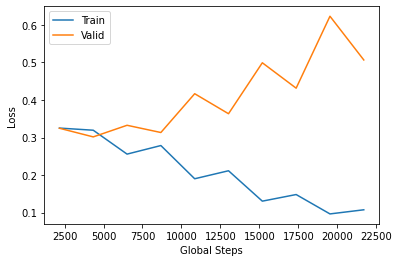

In [68]:
#plot the loss curve for both train and validation data 
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

## Model Evaluation

In [23]:
def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (comment,attack ), _ in test_loader:

                comment = comment.type(torch.LongTensor)           
                comment = comment.to(device)
                attack = attack.type(torch.LongTensor)  
                attack = attack.to(device)
                output = model(comment, attack)

                _, output = output
                # transform probablities into 0 or 1
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(attack.tolist())
    return y_true, y_pred

In [57]:
best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

y_true, y_pred = evaluate(best_model, test_iter)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== Model/model.pt


Classification Report:
              precision    recall  f1-score   support

           1     0.8150    0.4179    0.5525      3869
           0     0.8936    0.9810    0.9352     19275

    accuracy                         0.8868     23144
   macro avg     0.8543    0.6994    0.7439     23144
weighted avg     0.8804    0.8868    0.8713     23144



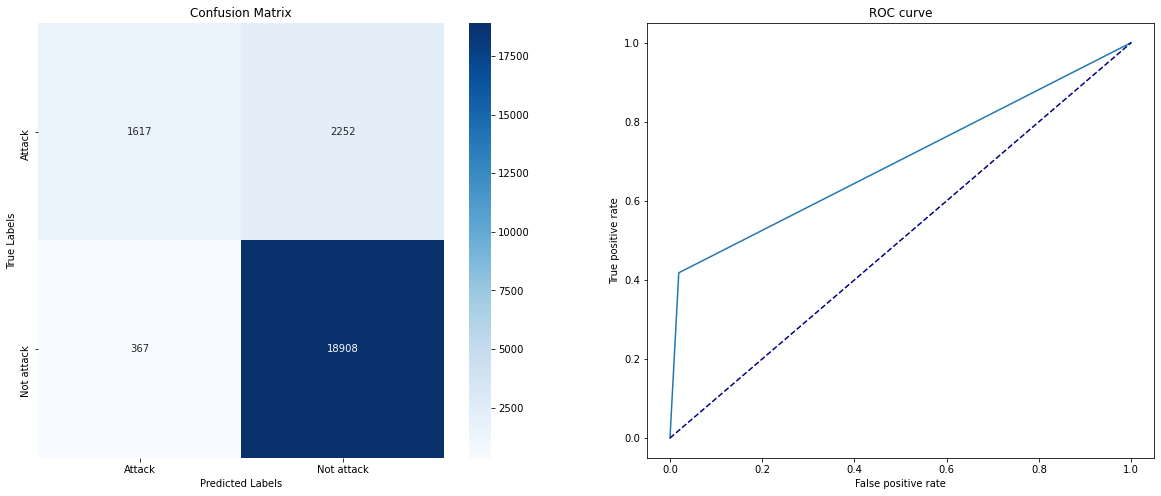

auc score: 0.6994486220075837


In [59]:
# evaluate model with auc and confusion matrix

print('Classification Report:')
print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

# confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[1,0])
plt.figure(1, figsize=(20,8))
ax= plt.subplot(121)
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(['Attack', 'Not attack'])
ax.yaxis.set_ticklabels(['Attack', 'Not attack'])

# roc curve
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_true, y_pred)
plt.subplot(122)
plt.plot(fpr_rt_lm, tpr_rt_lm)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

# auc score
print('auc score:', roc_auc_score(y_true, y_pred))